In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
import matplotlib
from numpy import inf

matplotlib.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings('ignore')
plt.style.use('seaborn')
plt.rcParams['font.family'] = 'Malgun Gothic'
%matplotlib inline

In [3]:
region = pd.read_csv('region_v2.csv')[['HDONG_NM','resident','tourism']]
flow_time_age = pd.read_csv('local_people_melt.csv')

--------------------

In [26]:
dfdf = pd.merge(flow_time_age,region,on='HDONG_NM',how='left')
dfdf['period'] = np.where(dfdf['STD_DD']<'2020-02-21','normal',
                          np.where(dfdf['STD_DD']<'2020-03-16','spread',
                                   np.where(dfdf['STD_DD']<'2020-05-06','ease', np.where(dfdf['STD_DD']>'2020-05-05','resilience','normal'))))
daystring = ['월','화','수','목','금','토','일']
dfdf['WEEKDAY'] = dfdf['WEEKDAY'].apply(lambda x: str(x)+'_'+daystring[x])

# 주거지역과 비주거지역

In [28]:
resident = dfdf.query('resident == 1').reset_index(drop=True)
non_resident = dfdf.query('resident == 0').reset_index(drop=True)

## 시간 X 코로나 기간(요일별)

#### 주거지역
=> 코로나가 심한 시기일수록 집에 있는 인구가 늘어남. **확산 > 완화 > 회복**<br>
=> 요일 5,6 : 주말일수록 주거지역에 생활인구가 많은데, 코로나의 진행 시기간의 차이가 크고, 코로나가 심했던 시기일수록 생활인구가 많음

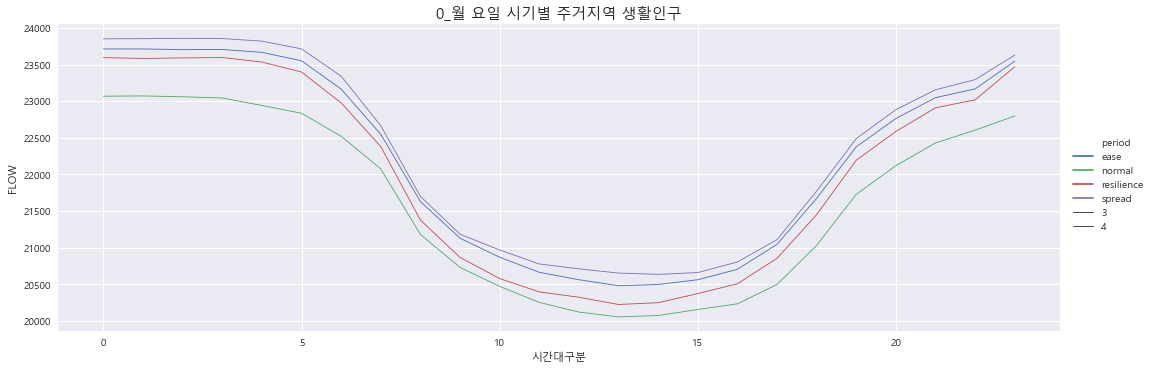

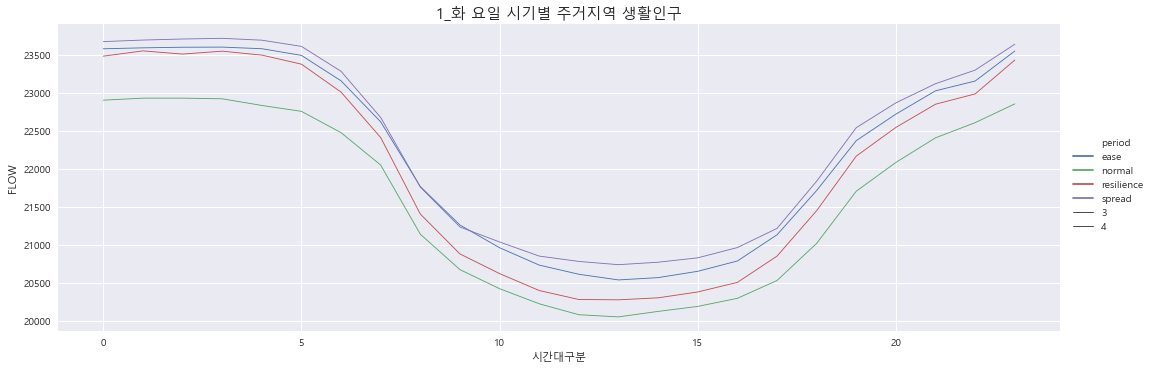

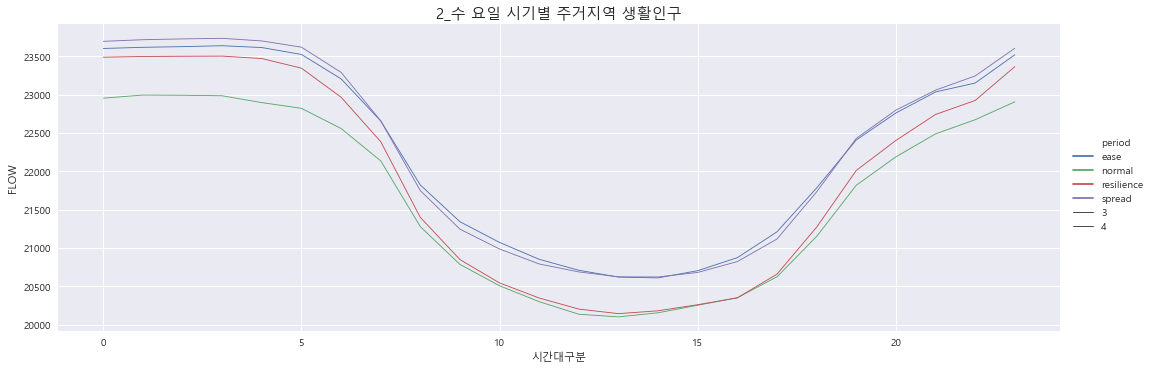

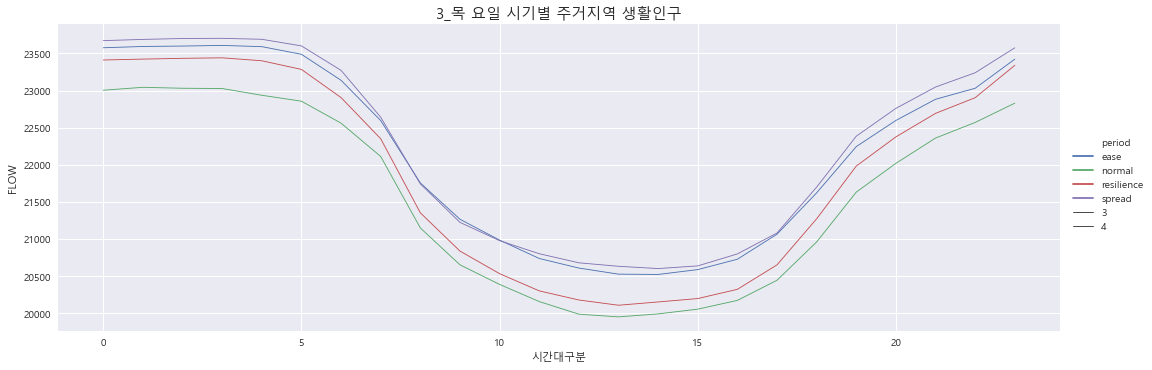

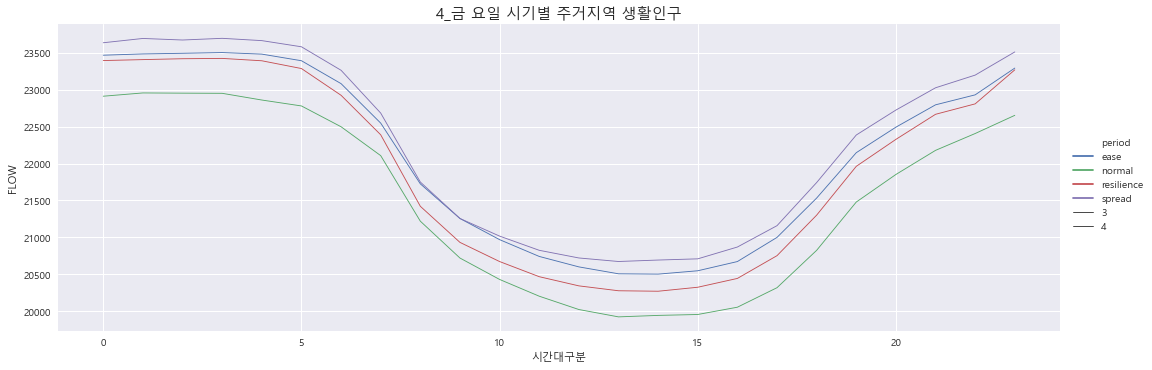

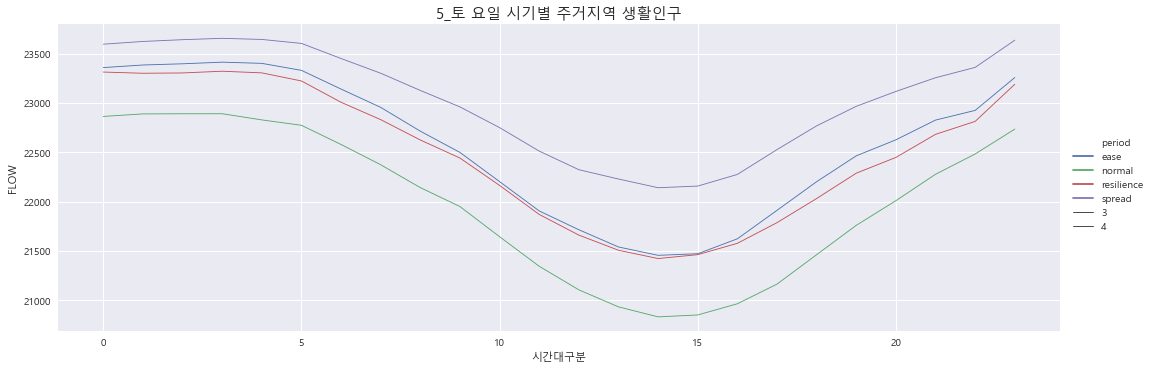

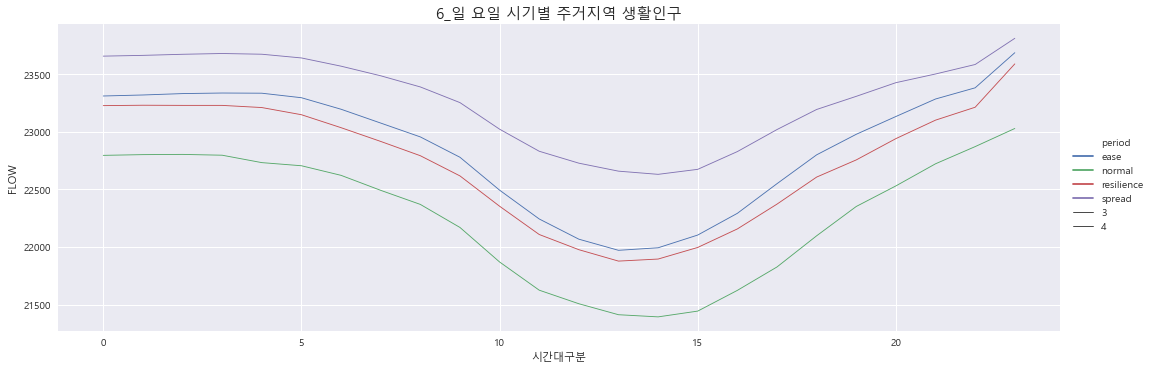

In [29]:
## 주거지역
temp = resident.groupby(['HDONG_NM','WEEKDAY','시간대구분','period'])[['FLOW']].mean()
temp = temp.groupby(['WEEKDAY','시간대구분','period'])[['FLOW']].sum().reset_index()
for i in temp['WEEKDAY'].unique():
    t = temp.loc[temp['WEEKDAY'] == i,:]
    ax = sns.relplot(data=t,x='시간대구분',y='FLOW',hue='period',kind='line',size=4,aspect=3)
    plt.title('{} 요일 시기별 주거지역 생활인구'.format(i),fontsize=15)
    plt.show()

#### 비주거지역
=> 주거지역과 역순으로 **평소>확산>완화>회복** 순으로 생활인구가 많음<br>
=> 주말일 때, 특정 낮 시간대에만 생활인구가 많음(관광지역과 비슷)

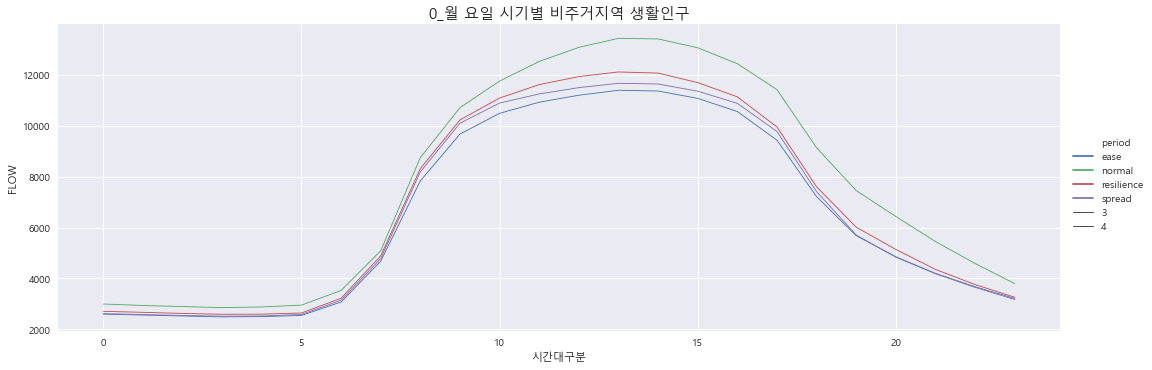

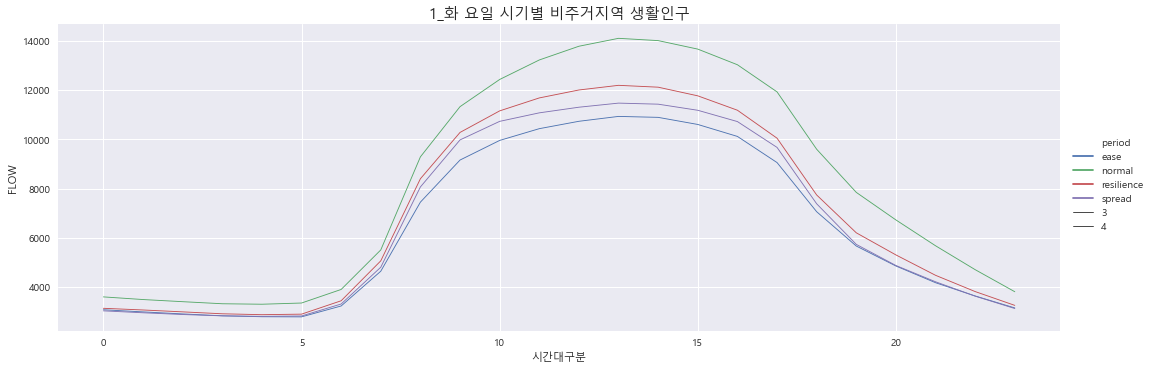

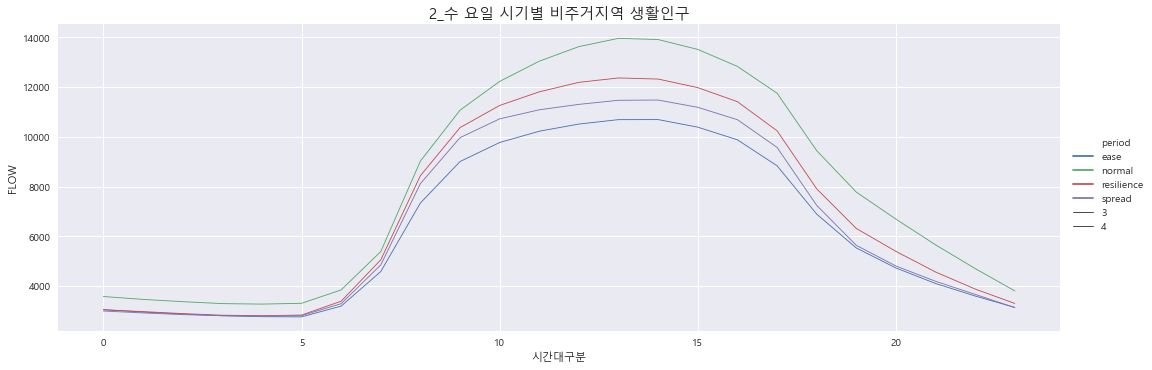

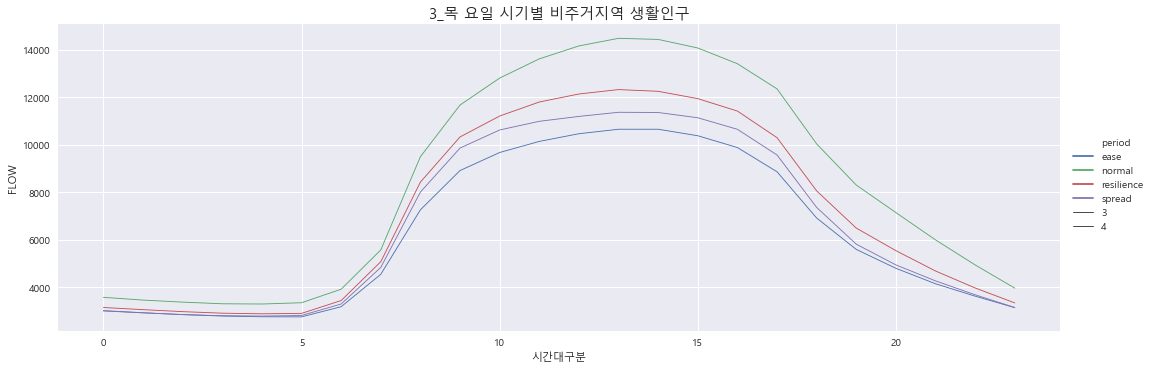

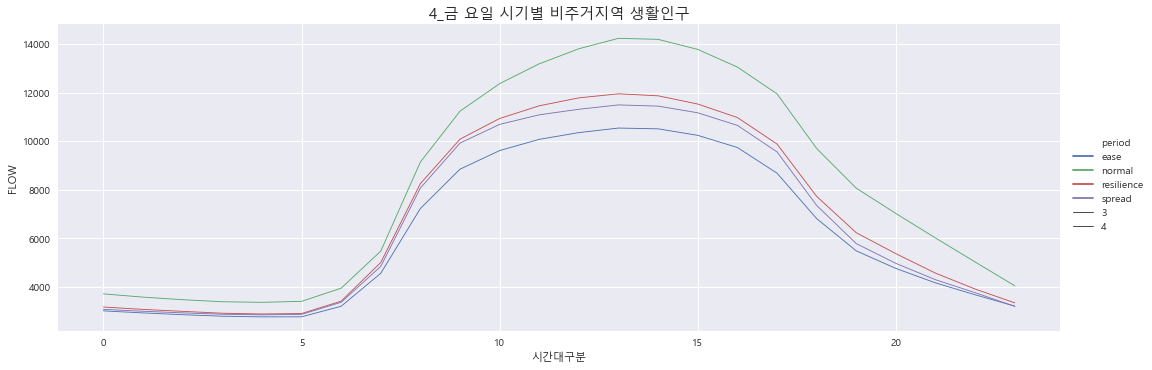

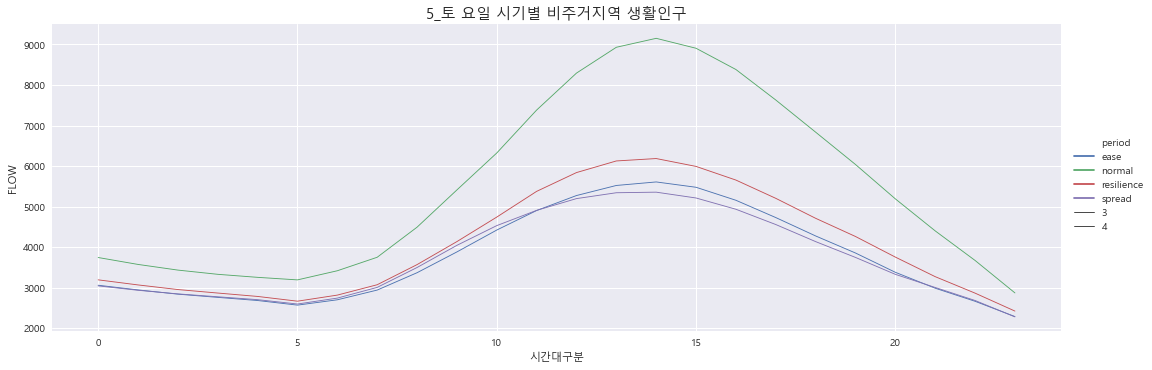

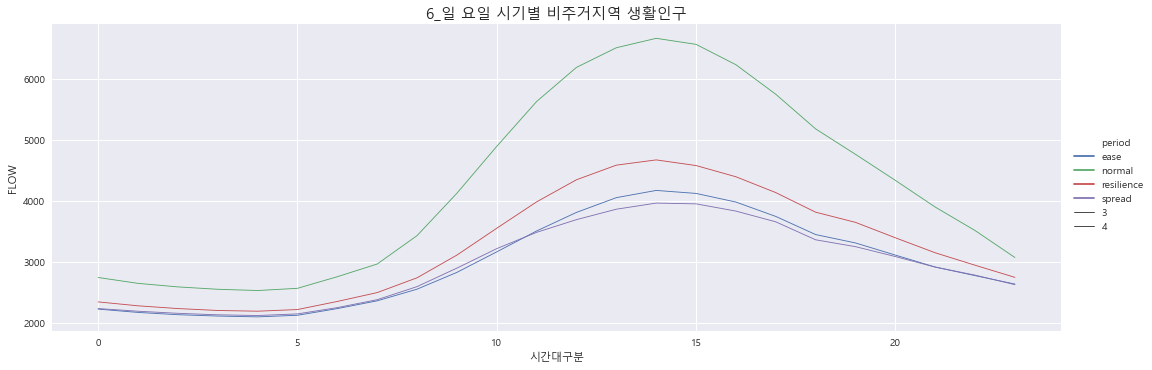

In [30]:
## 비주거지역
temp = non_resident.groupby(['HDONG_NM','WEEKDAY','시간대구분','period'])[['FLOW']].mean()
temp = temp.groupby(['WEEKDAY','시간대구분','period'])[['FLOW']].sum().reset_index()

for i in temp['WEEKDAY'].unique():
    t = temp.loc[temp['WEEKDAY'] == i,:]
    sns.relplot(data=t,x='시간대구분',y='FLOW',hue='period',kind='line',size=4,aspect=3)
    plt.title('{} 요일 시기별 비주거지역 생활인구'.format(i),fontsize=15)
    
plt.show()

## 시간 X 연령 X 코로나 기간

#### 주거지역과 비주거지역 간 차이
* 주거지역과 비주거지역 간 시간당 생활인구 패턴이 반대되었다는 점 이외에는 큰 차이가 없음<br>
* 주거지역의 생활인구 : 코로나 확산기>완화기>회복기>평소
* 60대 후반 이상 : 낮 시간대의 주거인구 수가 다른 연령대에 비해 많음. 코로나 확산기간에 가까울수록 주거지역에 있으려는 성향이 다른 연령대보다 많음. 특히 70세 이상이 압도적으로 주거지역의 생활인구가 많음.<br>
* 0세~14세 : 주로 주거 지역에 인구가 많은데 이는 어린이집, 학교 등이 주거지역에 위치해 있기 때문인 것으로 추정.(비주거지역과 Y축 비교했을 때 normal 기간에도 주거지역의 생활인구 수가 더 많다) 코로나 확산 이전보다 코로나 확산 이후에 모든 시간대에서 확실히 생활인구 수가 늘어나는데, 이는 원격수업의 영향인 것으로 보임<br>
* 15세~ 19세 : **normal 시기에 주거지역과 비주거지역의 패턴이 비슷한데**(밤에 줄어들고 낮에 늘어난 모양, 그러나 최대치와 최소치 간 범위가 그렇게 크지는 않음) => 코로나 이전 시기 때 평일에만 이런 패턴이 나타나는 것으로 보아 학교 때문인 것으로 추정. 코로나가 터진 후에는 0세~14세의 시간대별 주거인구 흐름과 비슷한 것으로 보아 원격수업의 영향이 있는 것으로 추측. 그리고 코로나 이전 시기의 주말에는 주거지역에 거의 없었는데, 코로나 터진 이후 주말에도 주거지역에 있는 인구 증가

### Heatmap

In [31]:
def rnr_category_time_with_period_graph(data, period, category):
    t_df = data.query('resident == 1')
    t_df = t_df.query('period in "{}"'.format(period)).groupby(['STD_DD','HDONG_NM','시간대구분',category])[['FLOW']].mean().reset_index()
    t_df = t_df.groupby(['STD_DD','시간대구분',category])[['FLOW']].sum().reset_index()
    f_df = data.query('resident == 0')
    f_df = f_df.query('period in "{}"'.format(period)).groupby(['STD_DD','HDONG_NM','시간대구분',category])[['FLOW']].mean().reset_index()
    f_df = f_df.groupby(['STD_DD','시간대구분',category])[['FLOW']].sum().reset_index()
    
    for i in data[category].unique():
        fig, axes = plt.subplots(ncols=2, figsize=(16, 12))
        r = t_df.query('{} == "{}"'.format(category, i))[['STD_DD','시간대구분','FLOW']]
        nr = f_df.query('{} == "{}"'.format(category, i))[['STD_DD','시간대구분','FLOW']]
        r = pd.pivot_table(r,index='STD_DD',columns='시간대구분',values='FLOW')
        nr = pd.pivot_table(nr,index='STD_DD',columns='시간대구분',values='FLOW')
        sns.heatmap(r,cmap='YlGnBu',ax=axes[0])
        axes[0].set_title('{} 기간동안 {} 시간별 주거지역 생활인구'.format(period,i))
        sns.heatmap(nr,cmap='YlGnBu',ax=axes[1])
        axes[1].set_title('{} 기간동안 {} 시간별 비주거지역 생활인구'.format(period,i))
        plt.show()

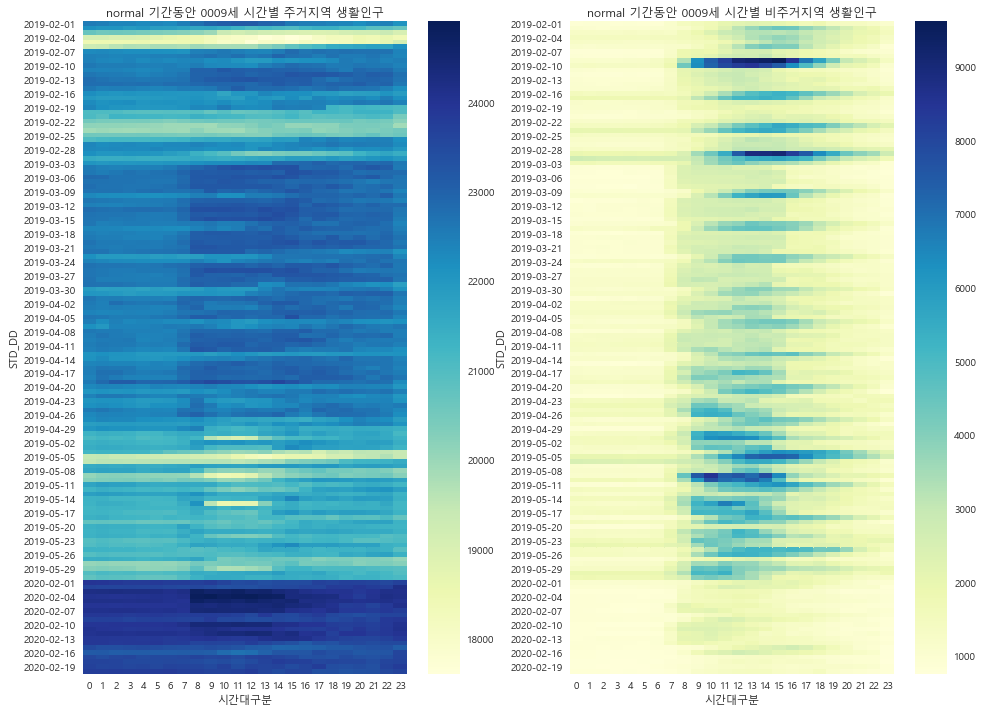

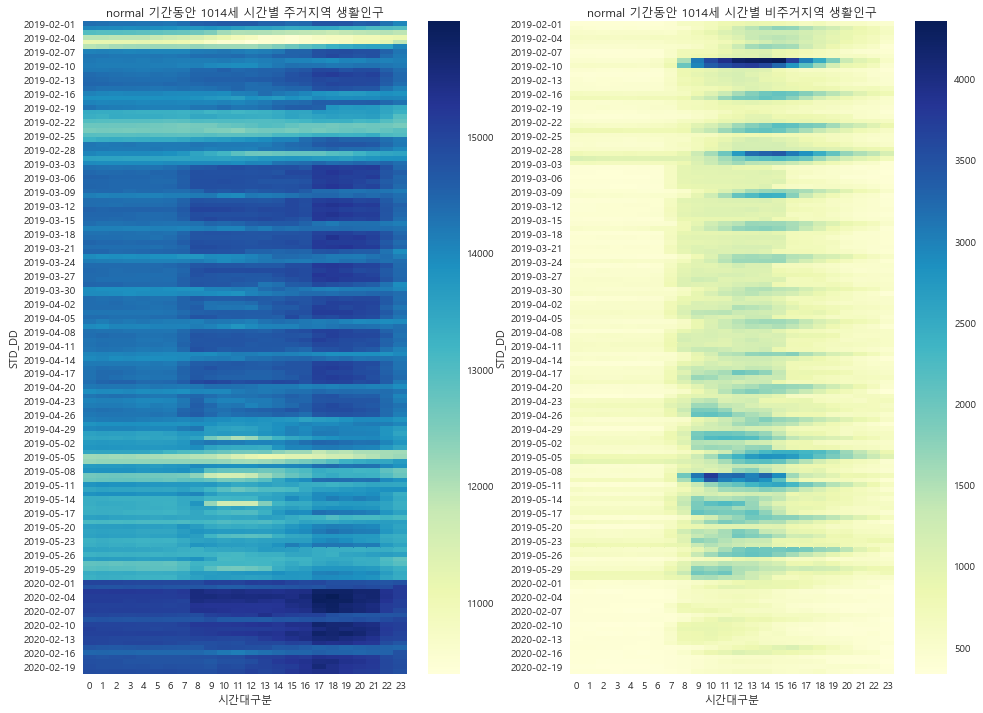

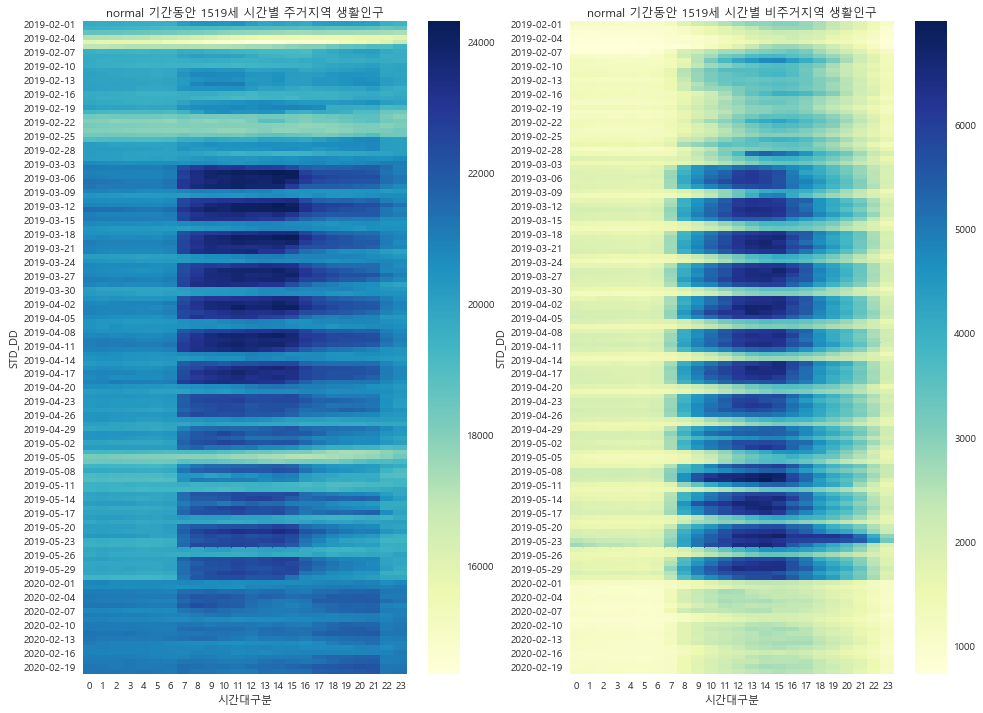

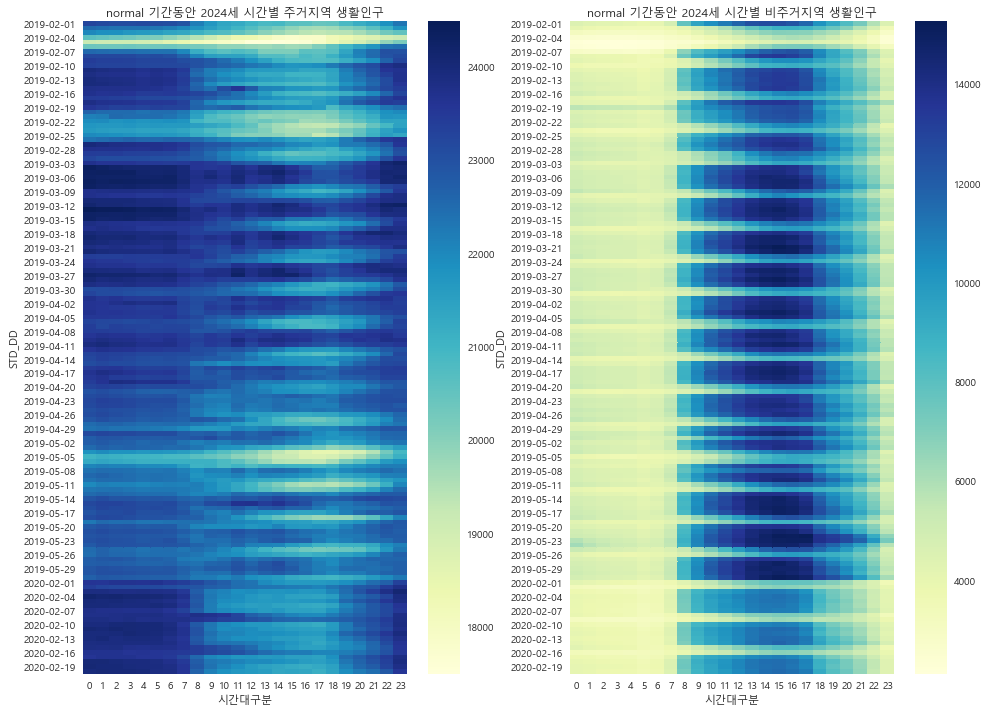

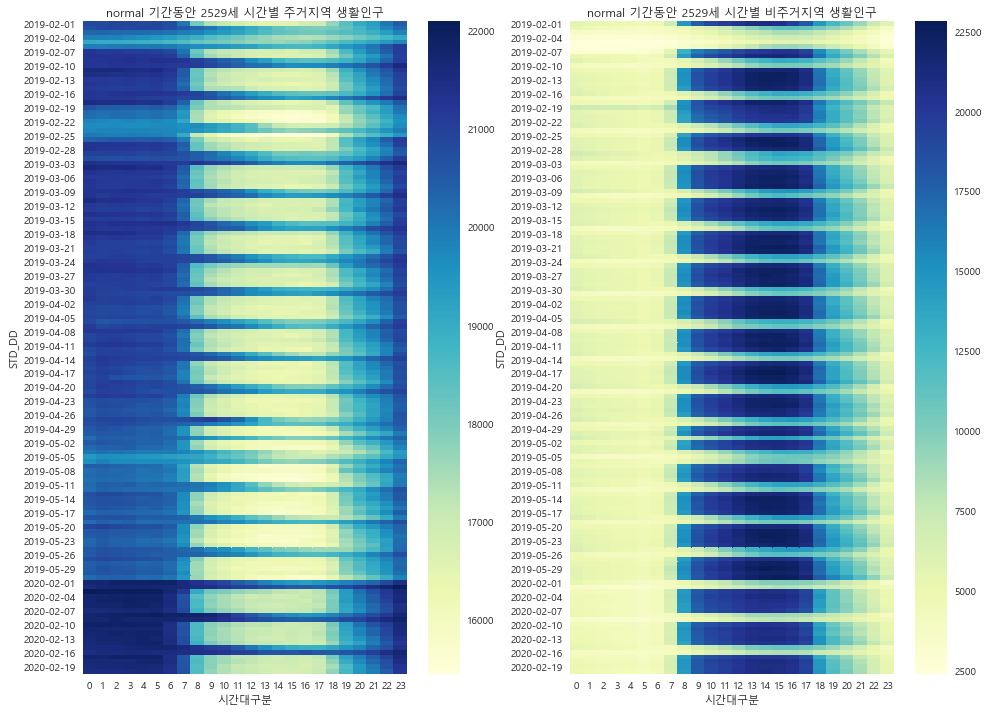

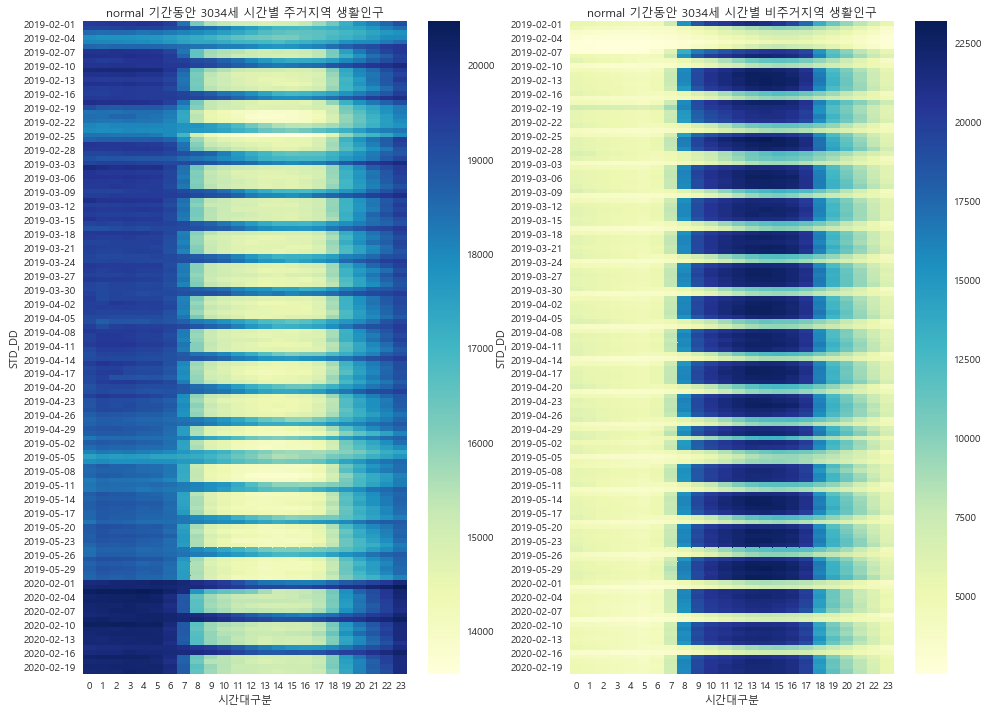

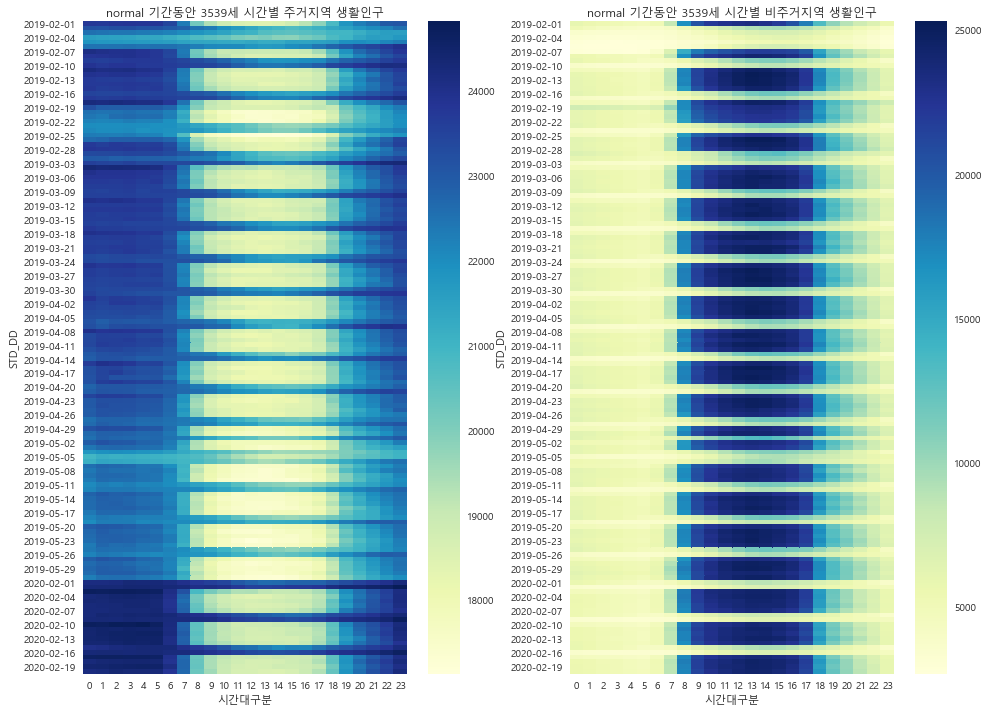

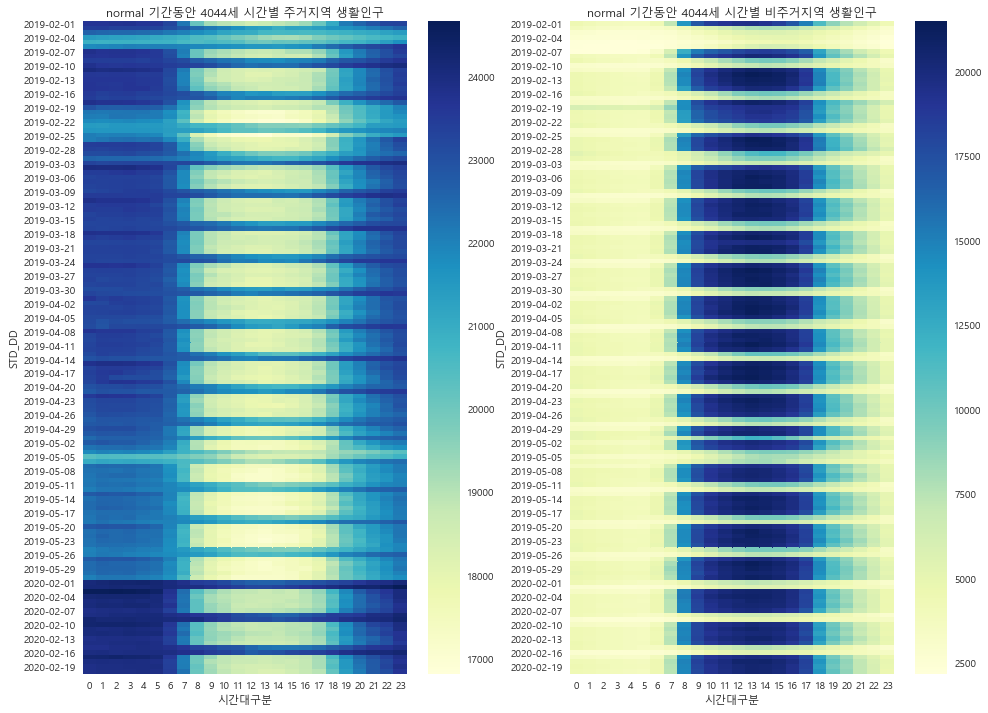

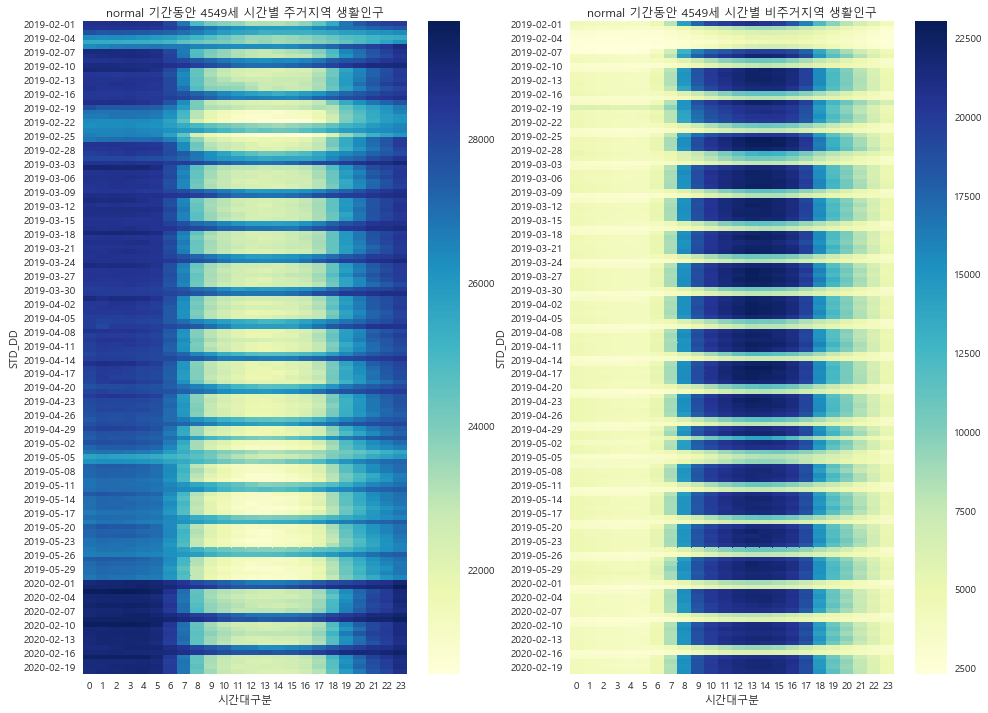

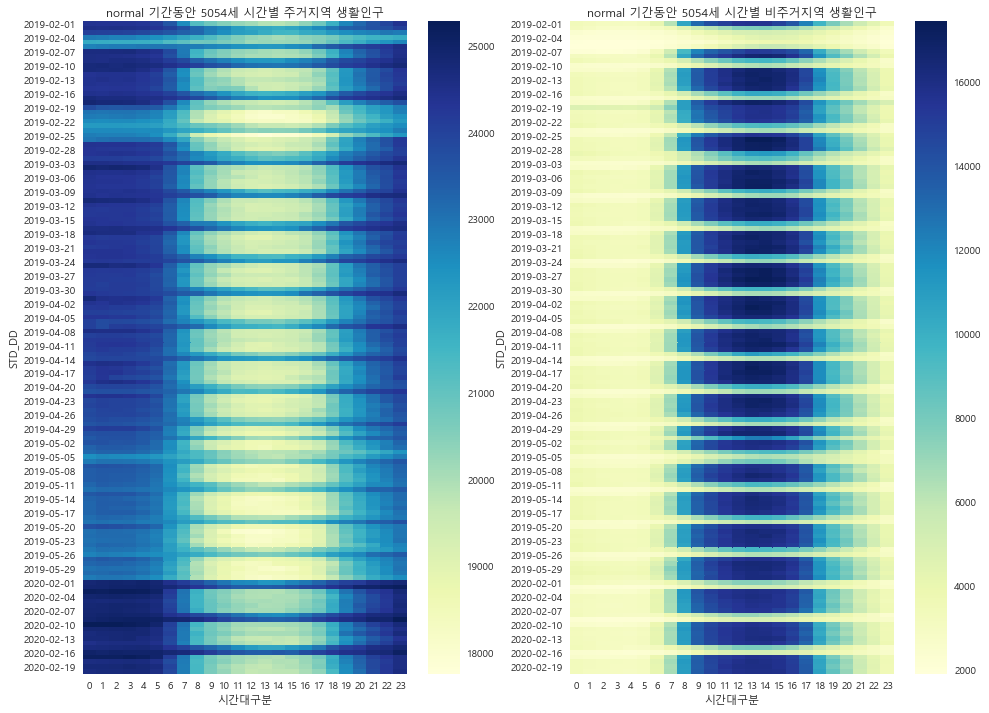

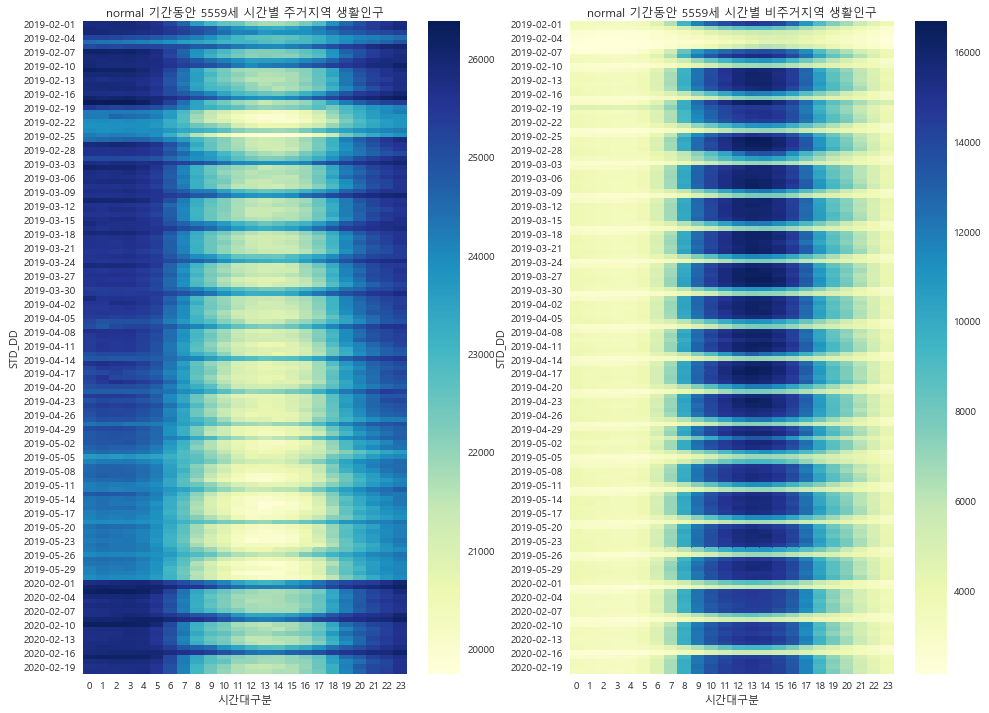

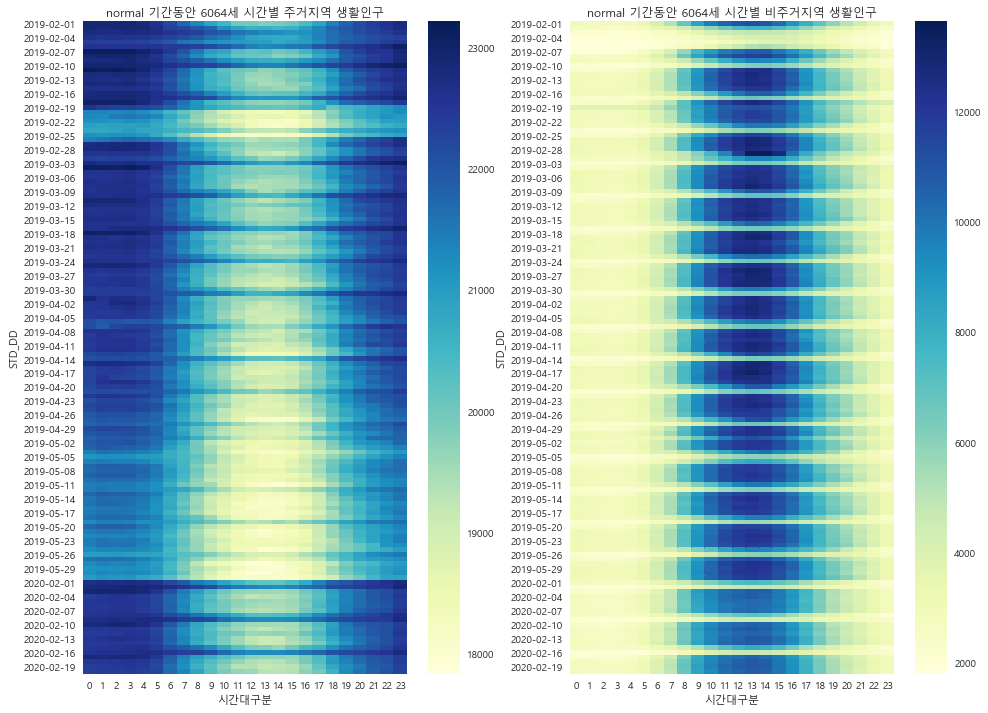

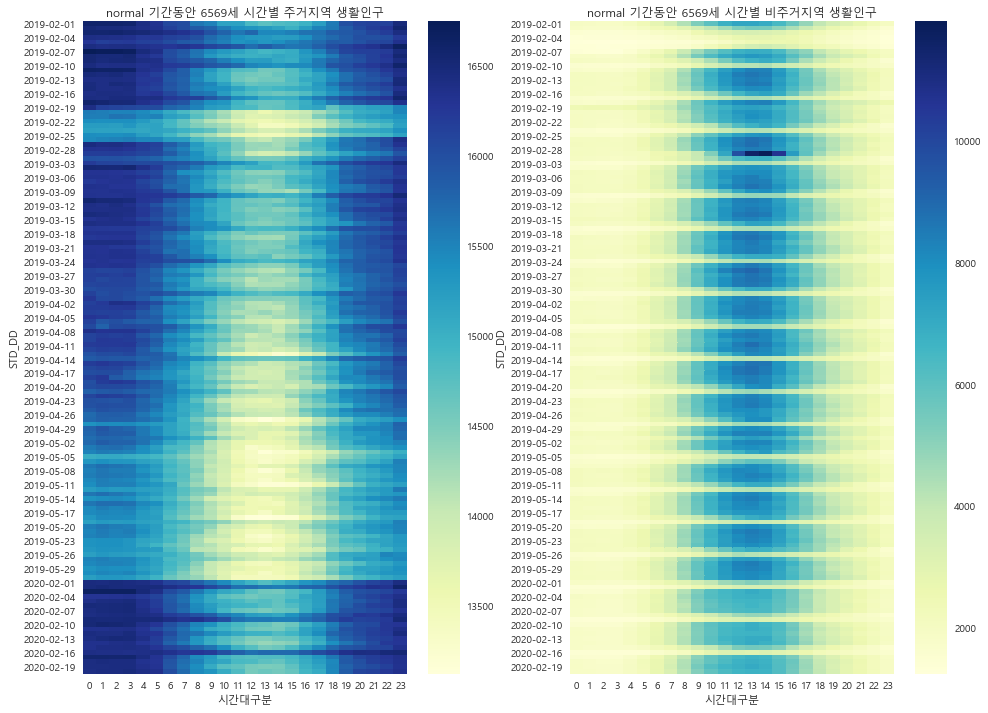

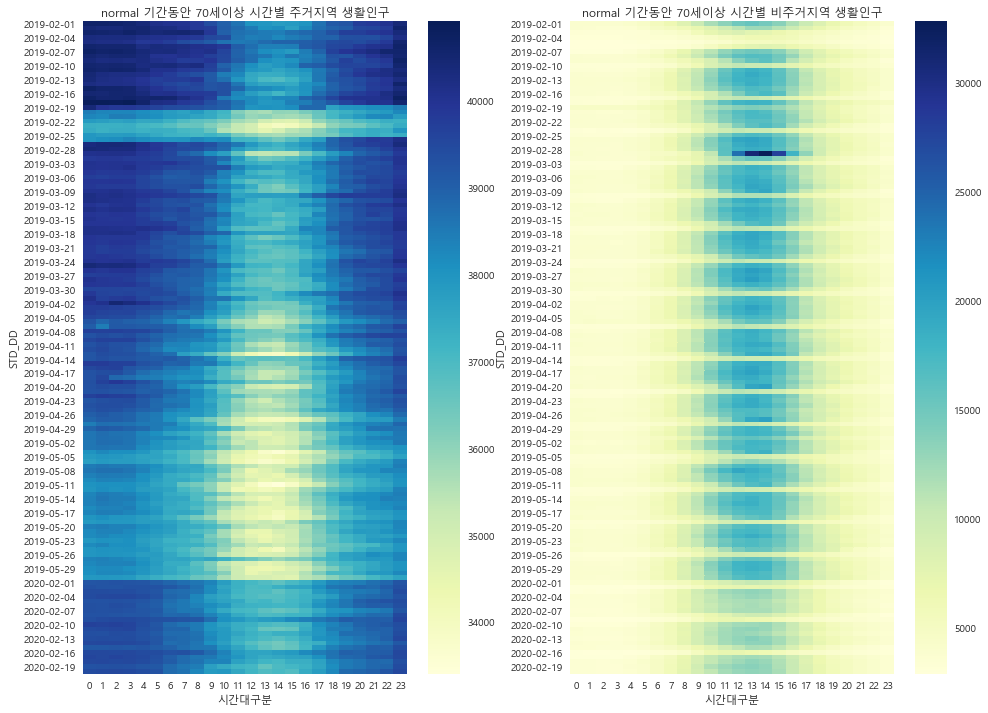

In [32]:
rnr_category_time_with_period_graph(dfdf,'normal','AGE_CD')

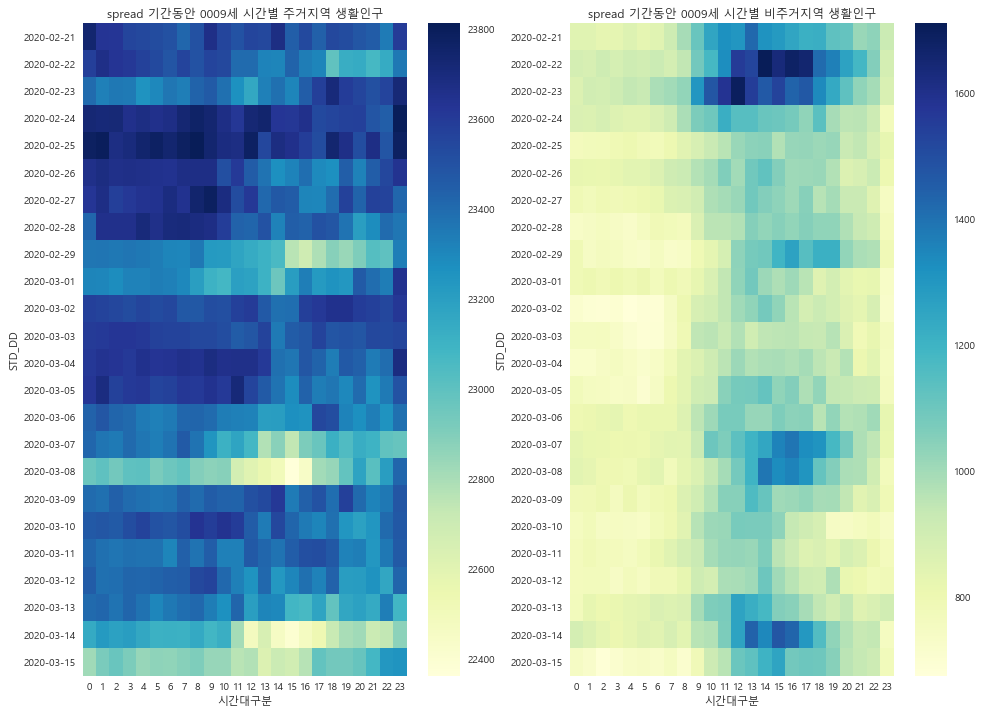

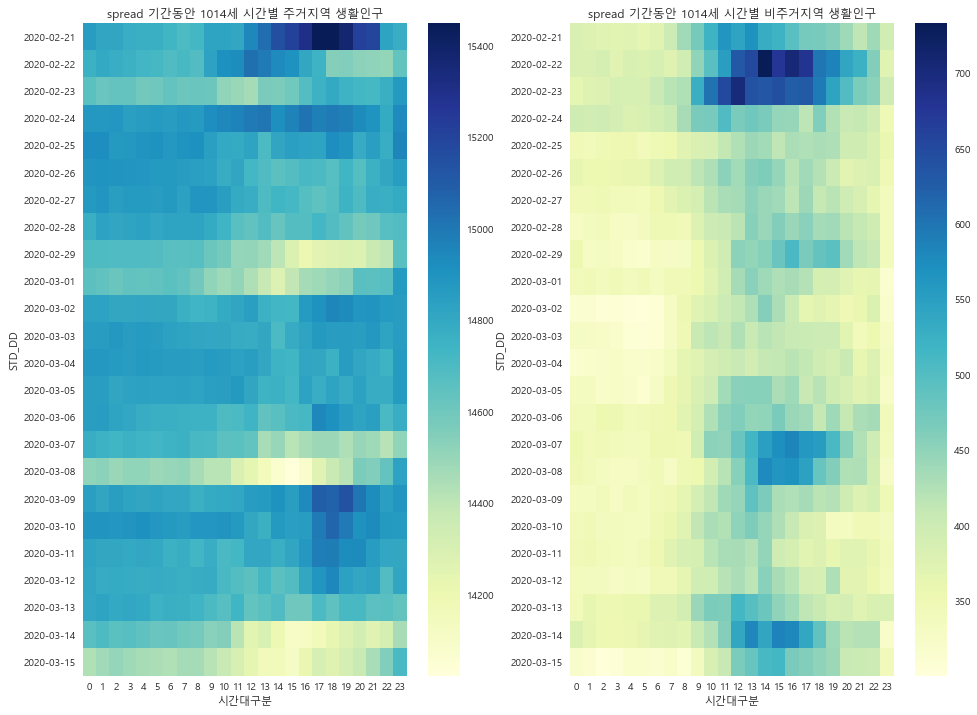

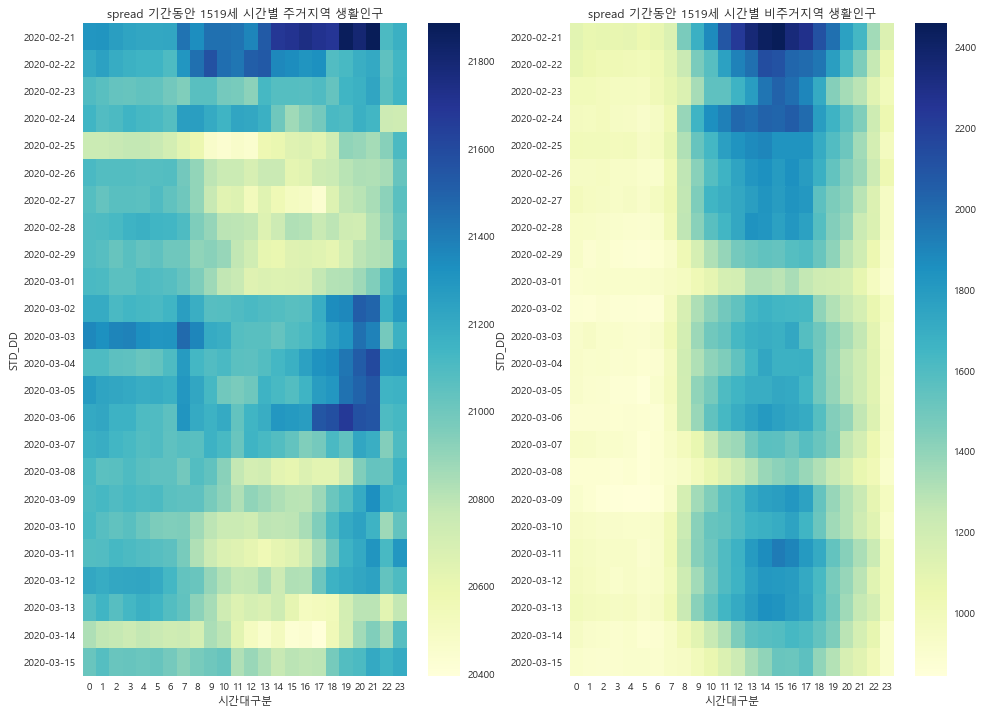

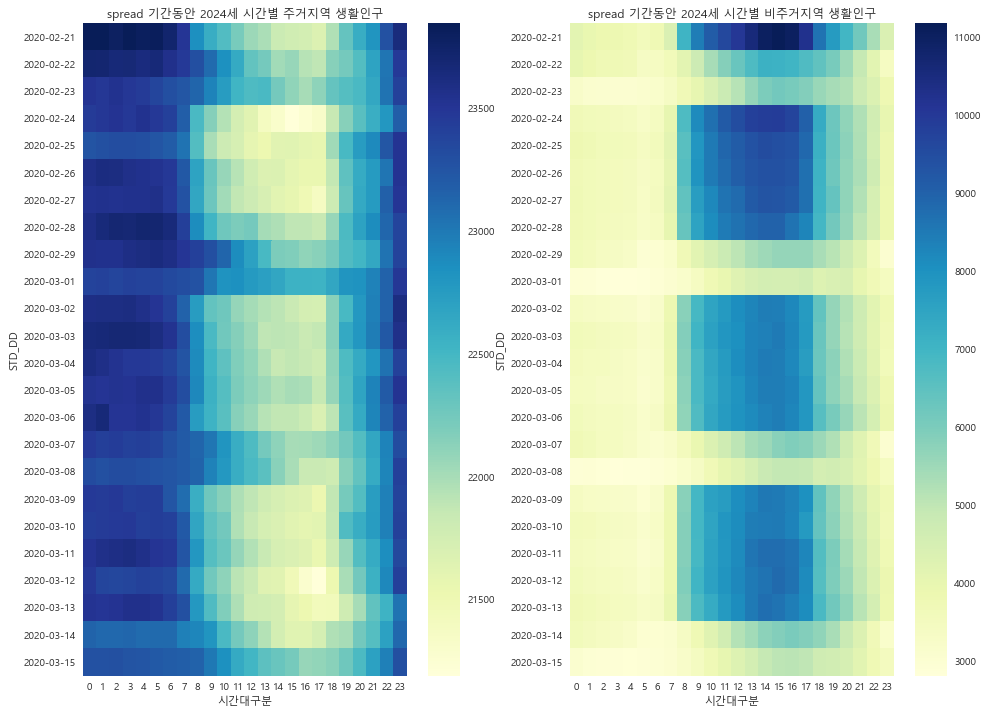

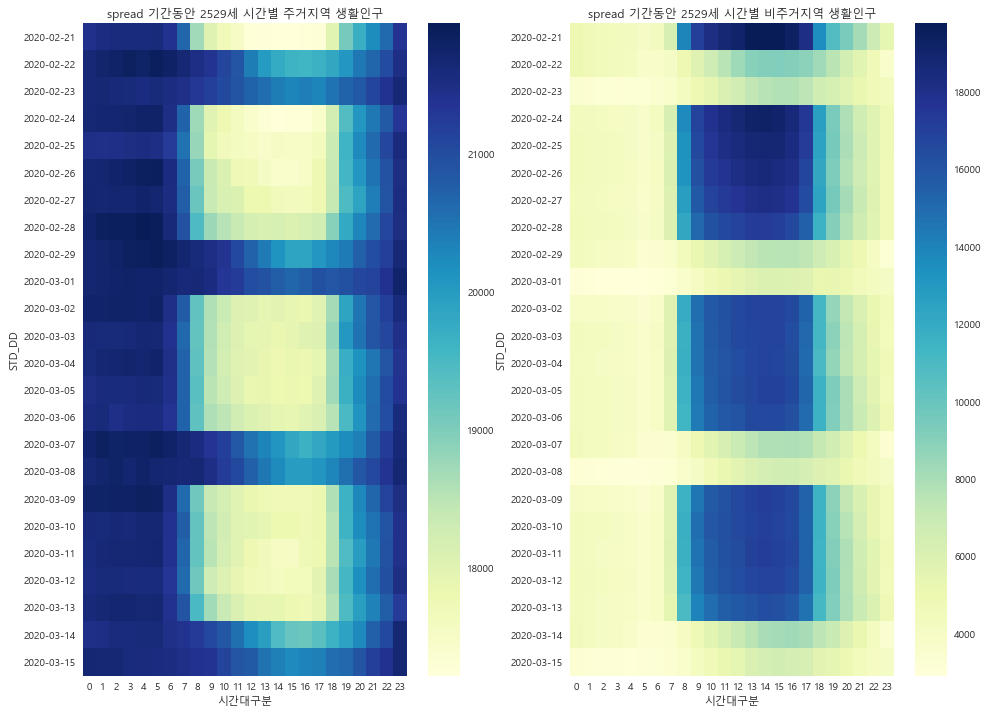

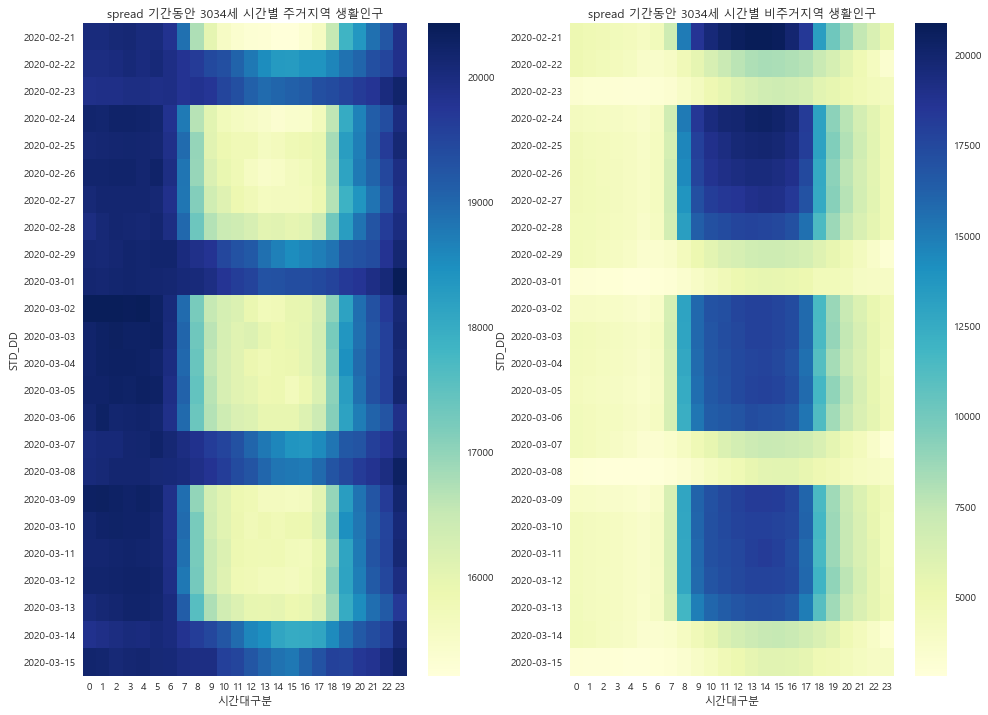

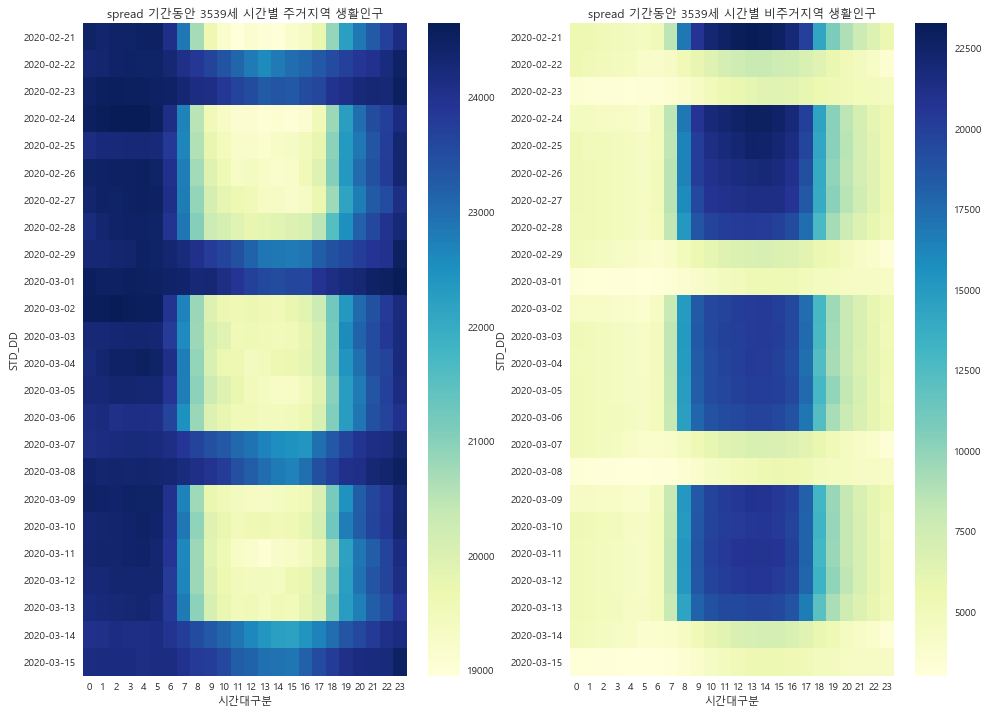

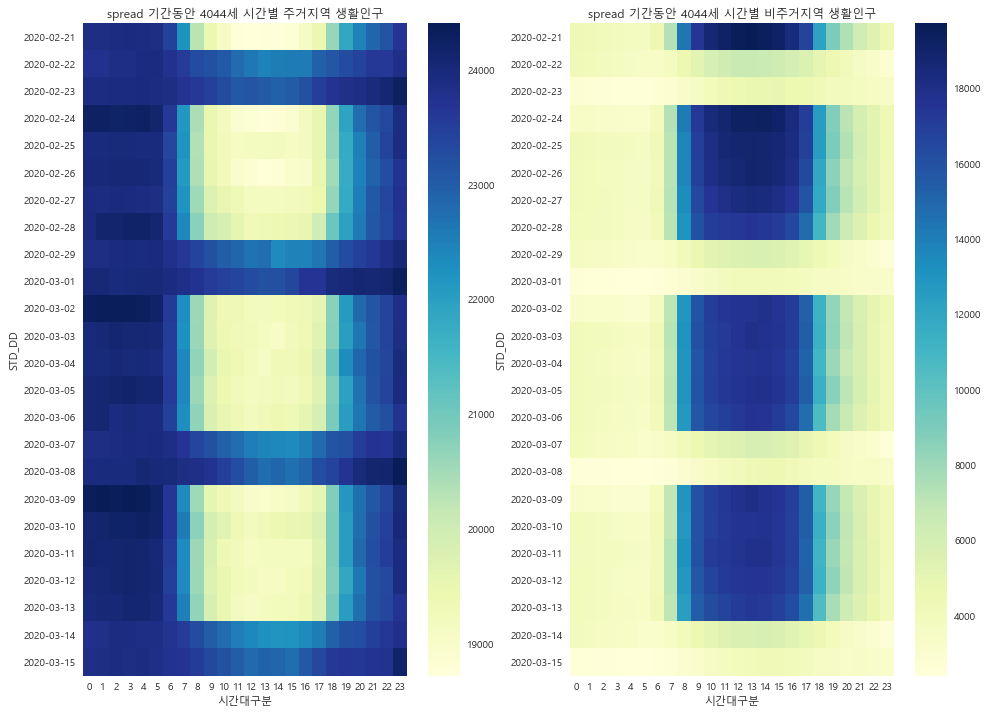

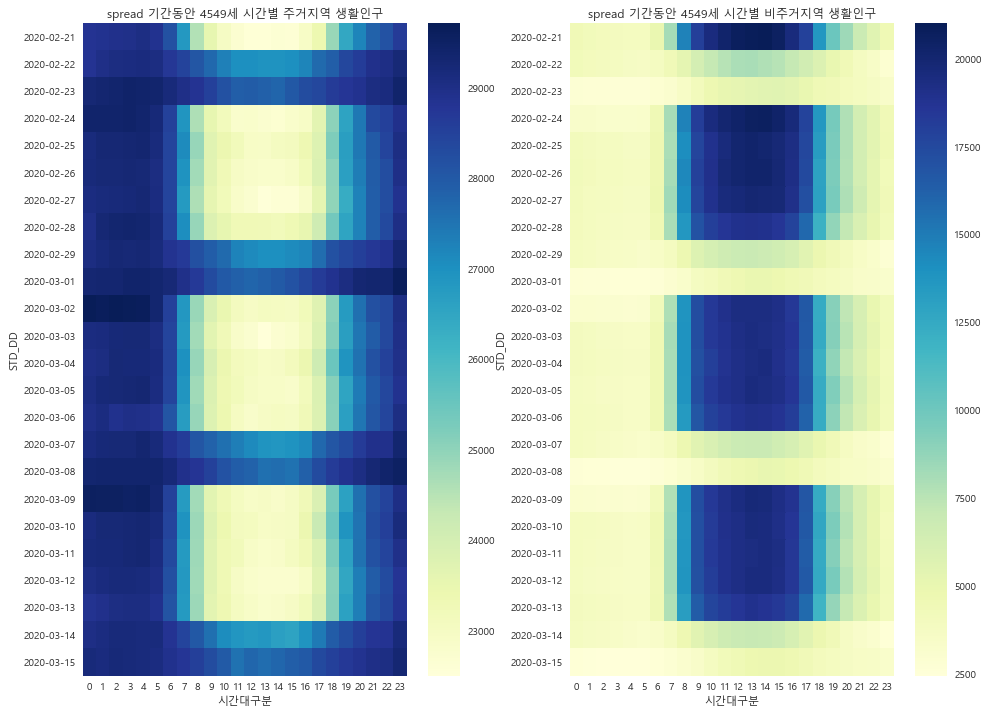

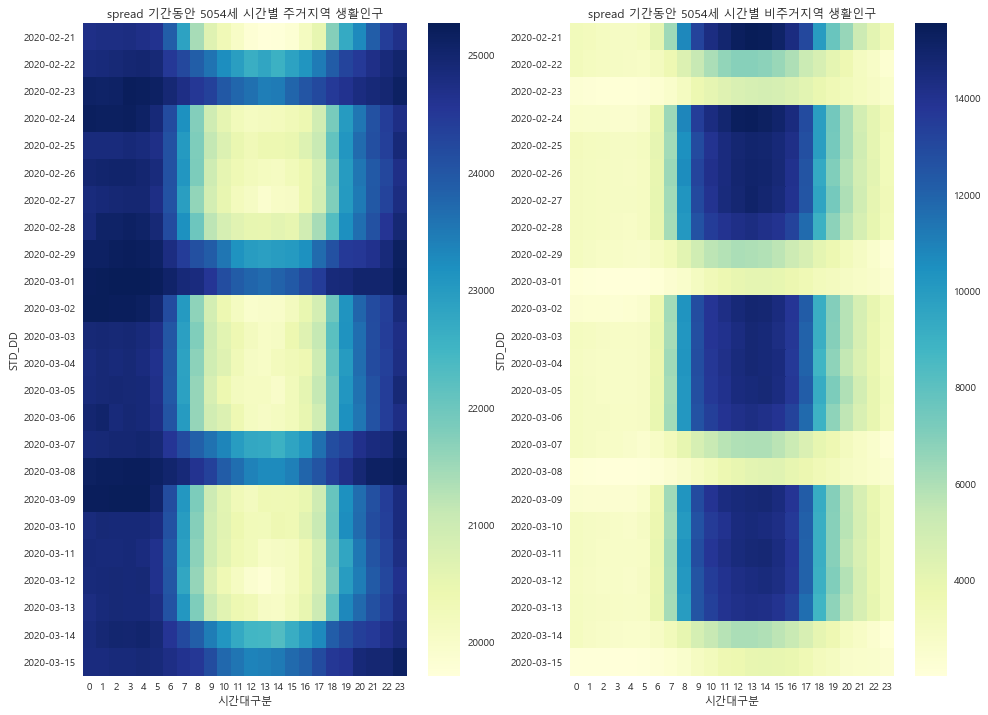

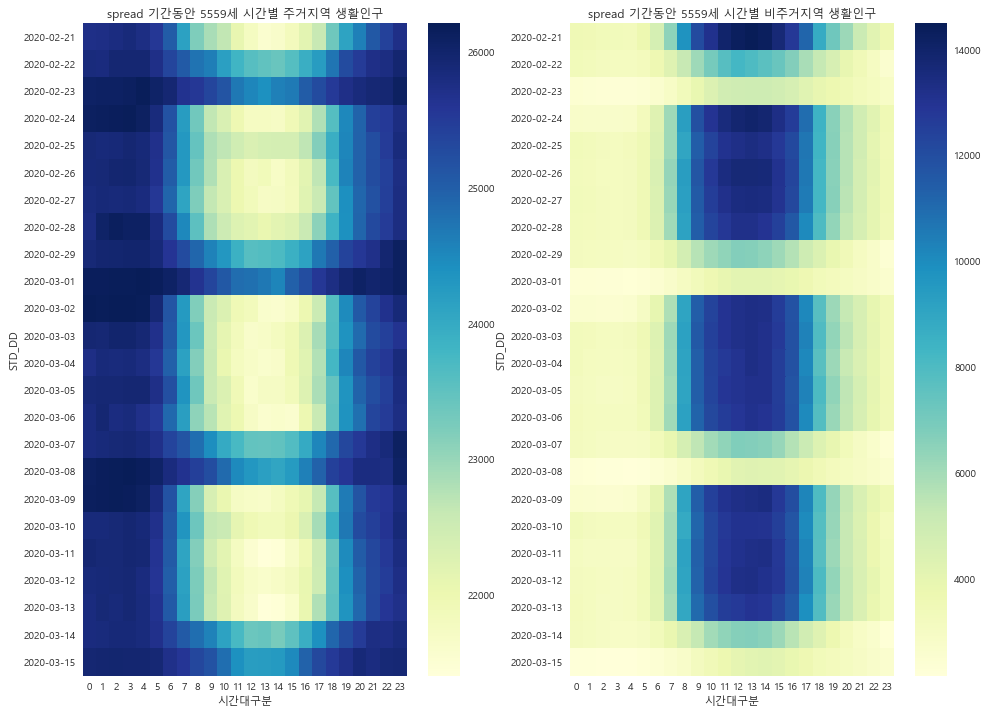

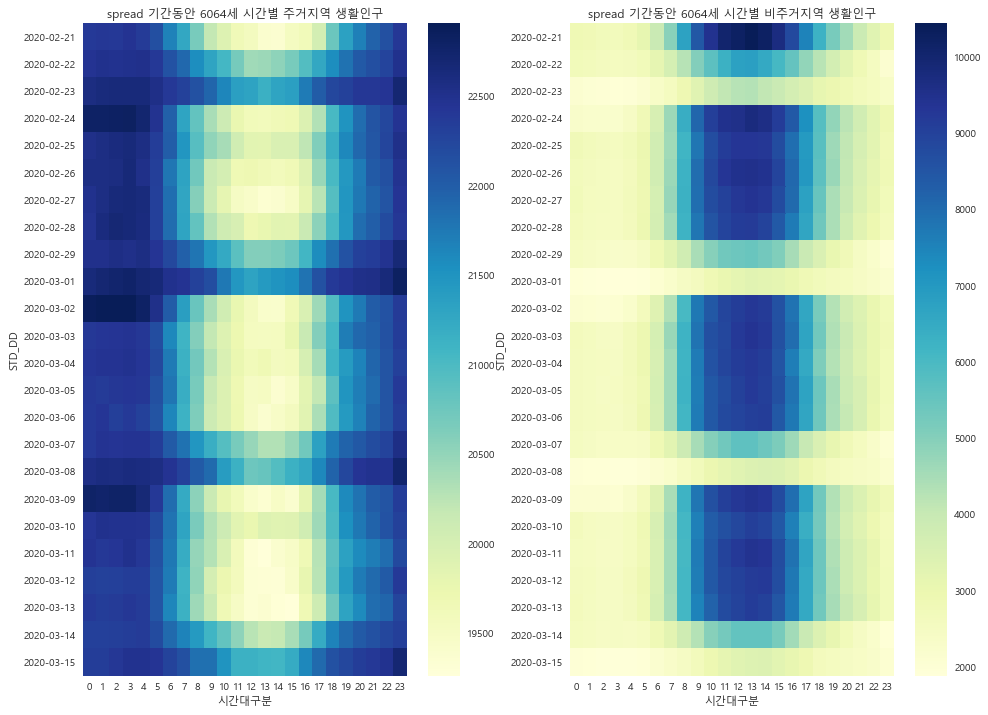

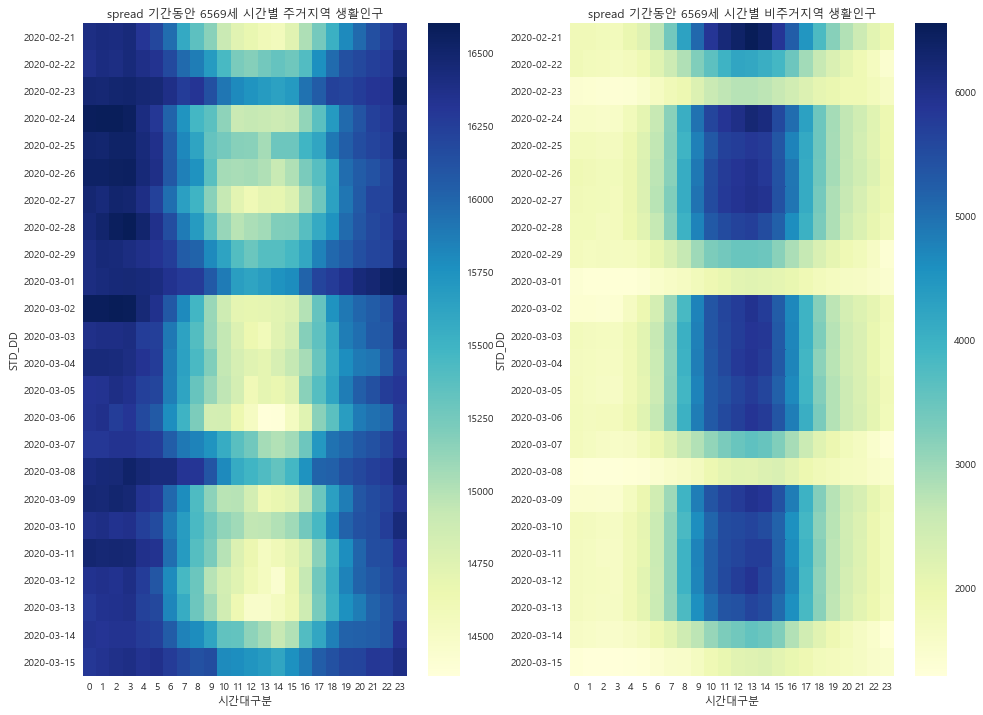

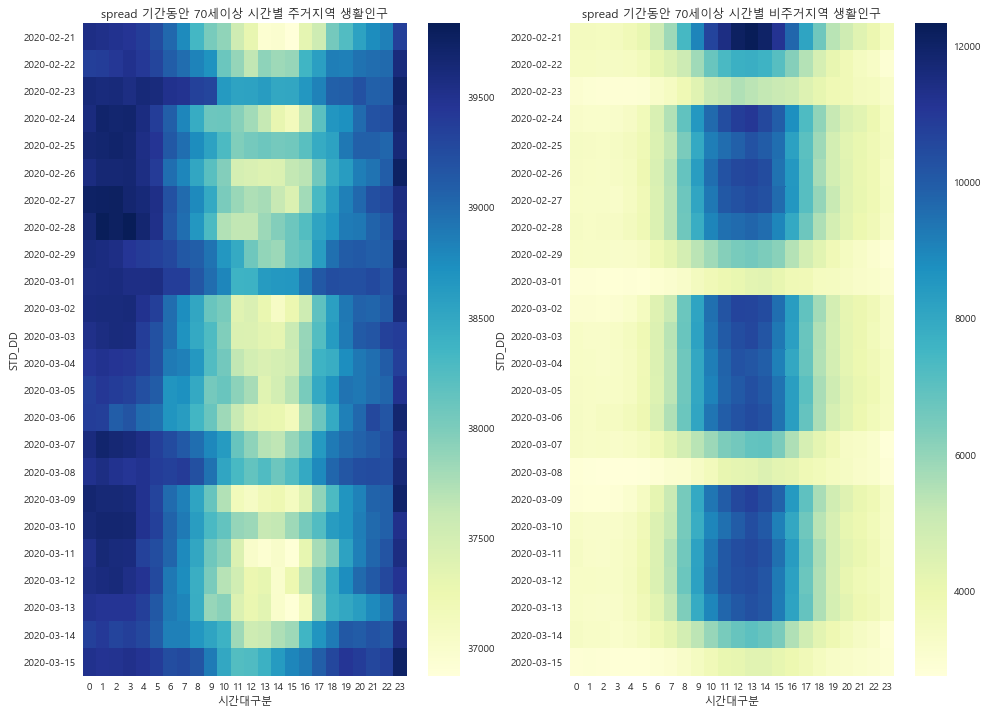

In [33]:
rnr_category_time_with_period_graph(dfdf,'spread','AGE_CD')

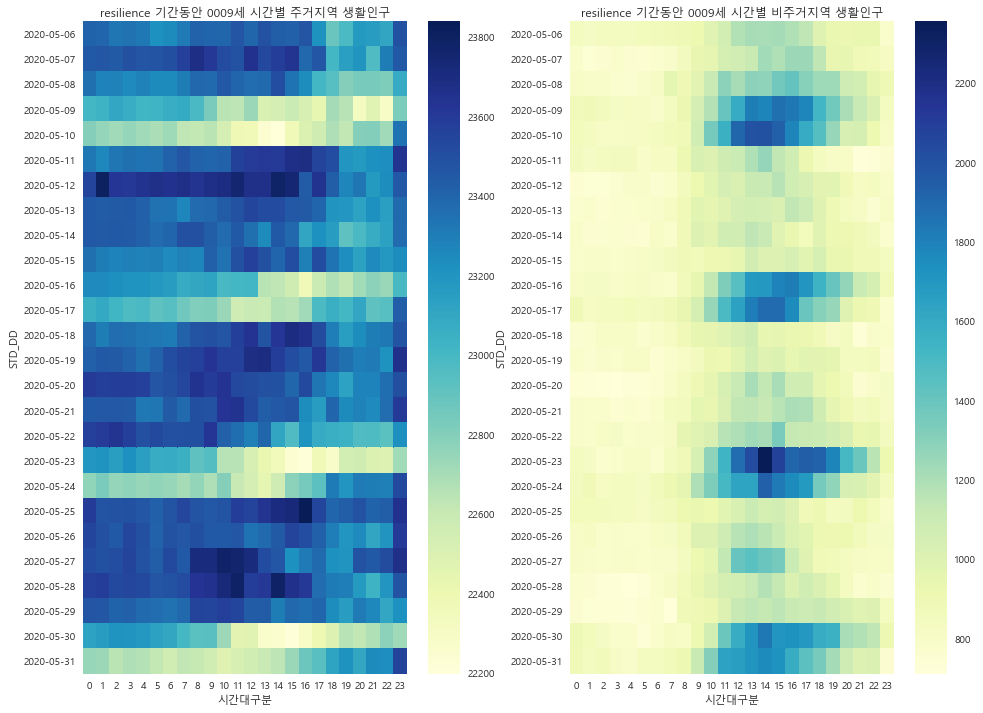

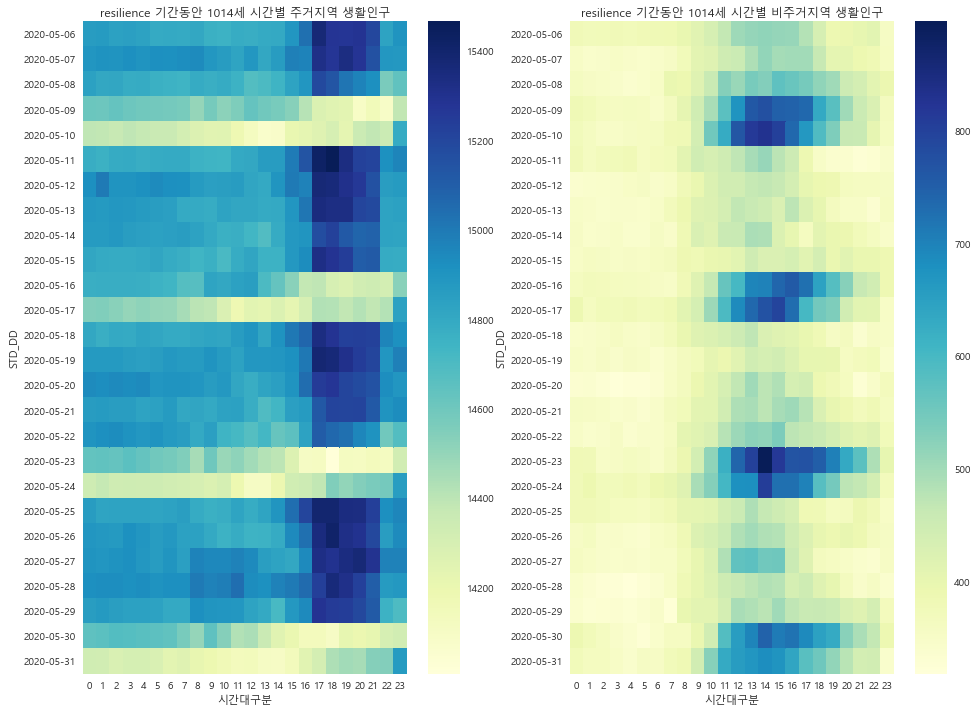

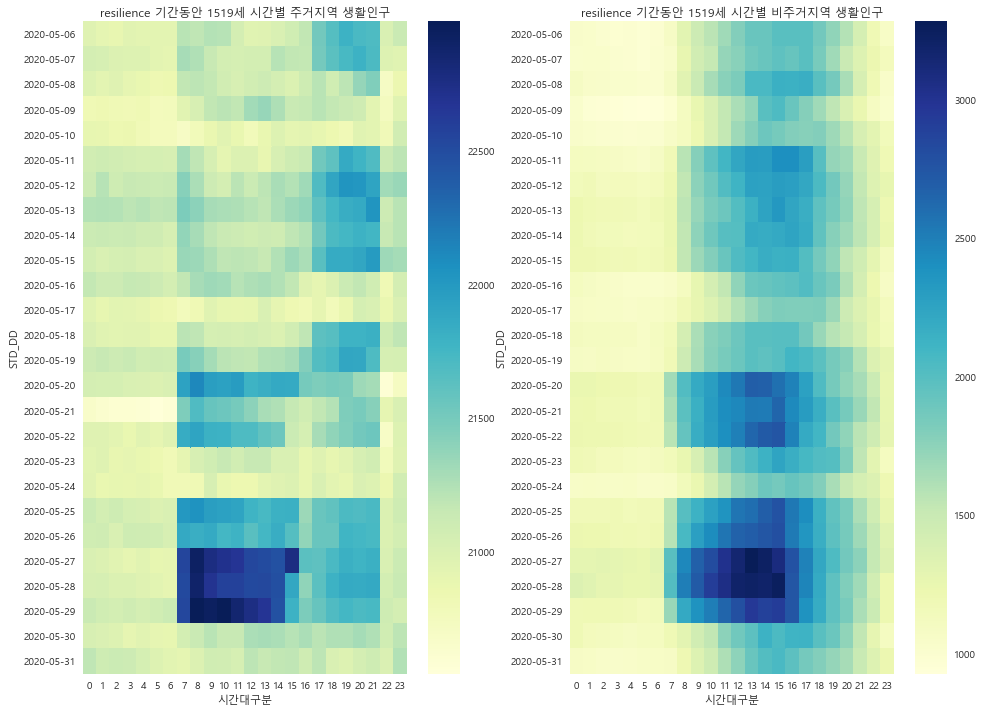

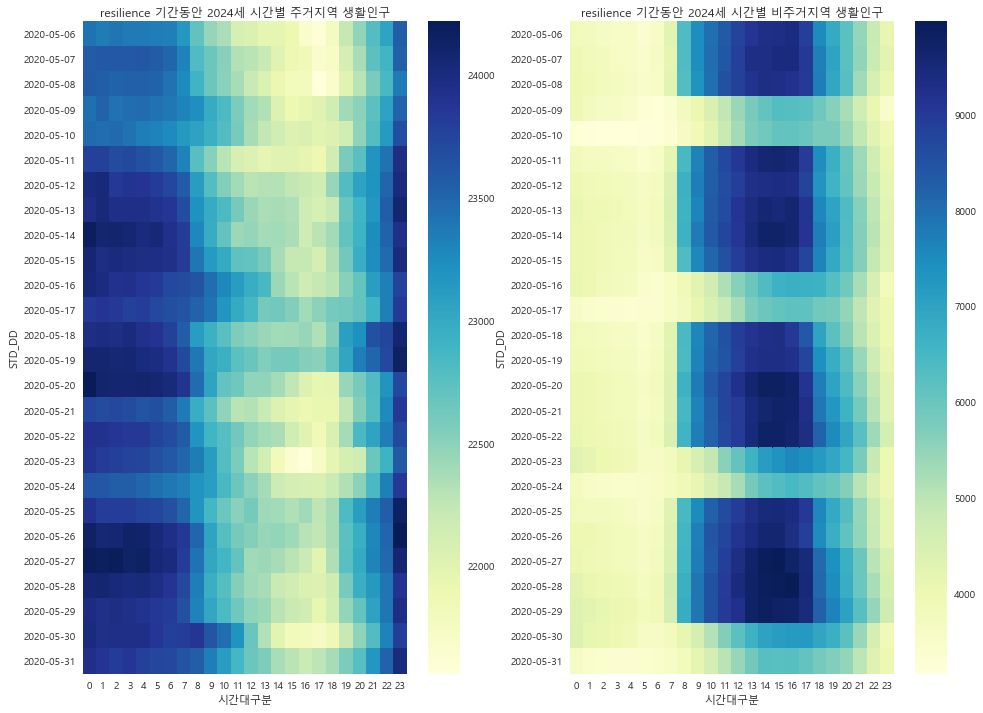

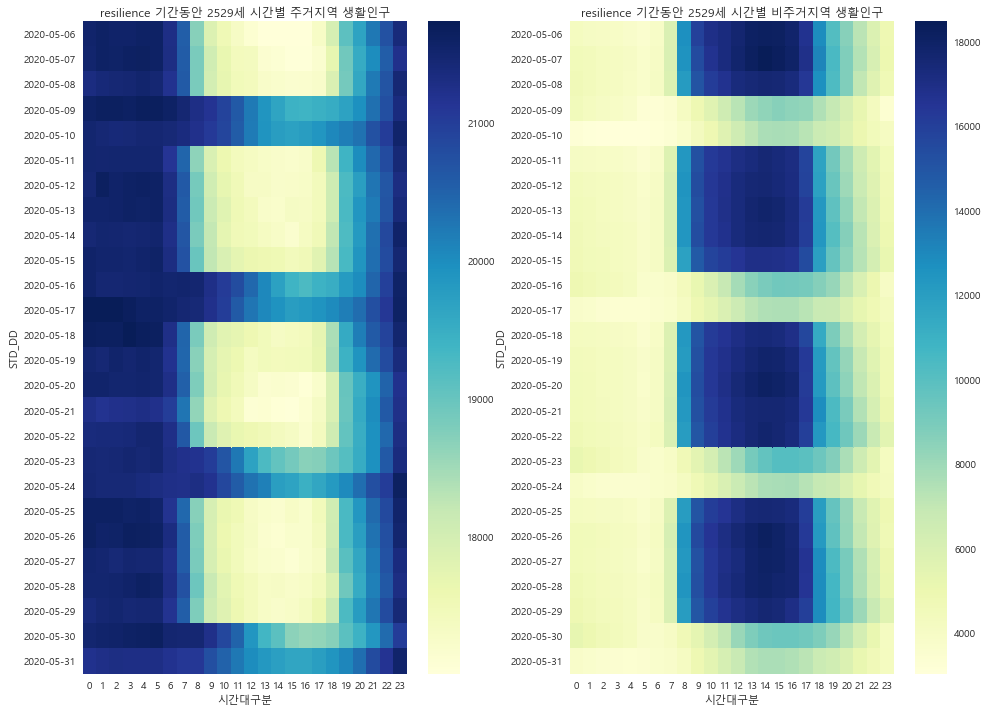

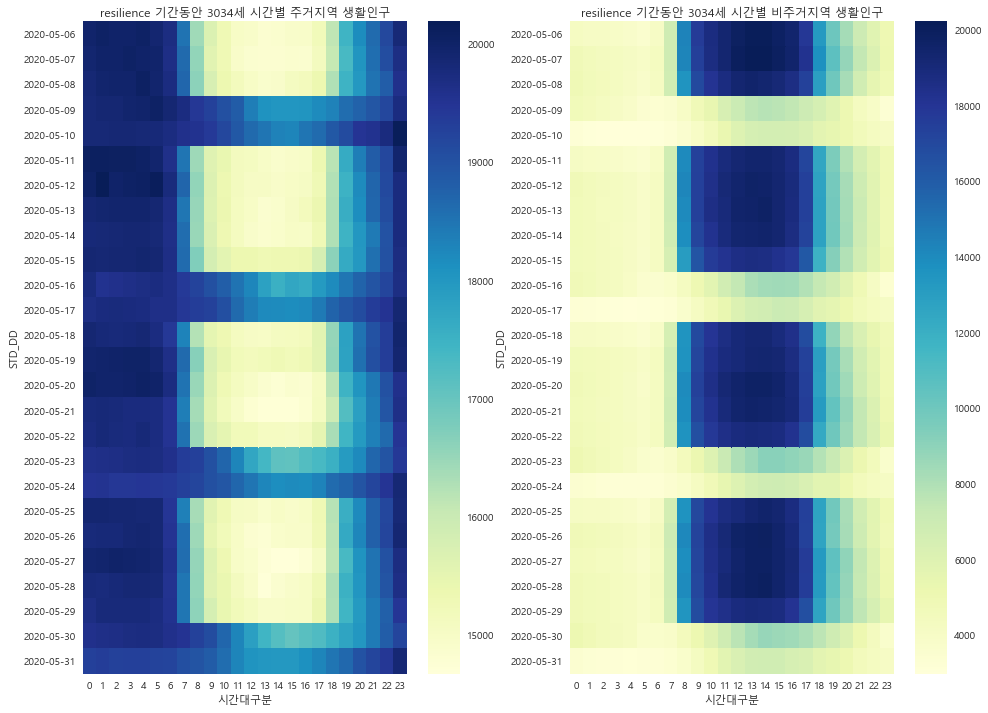

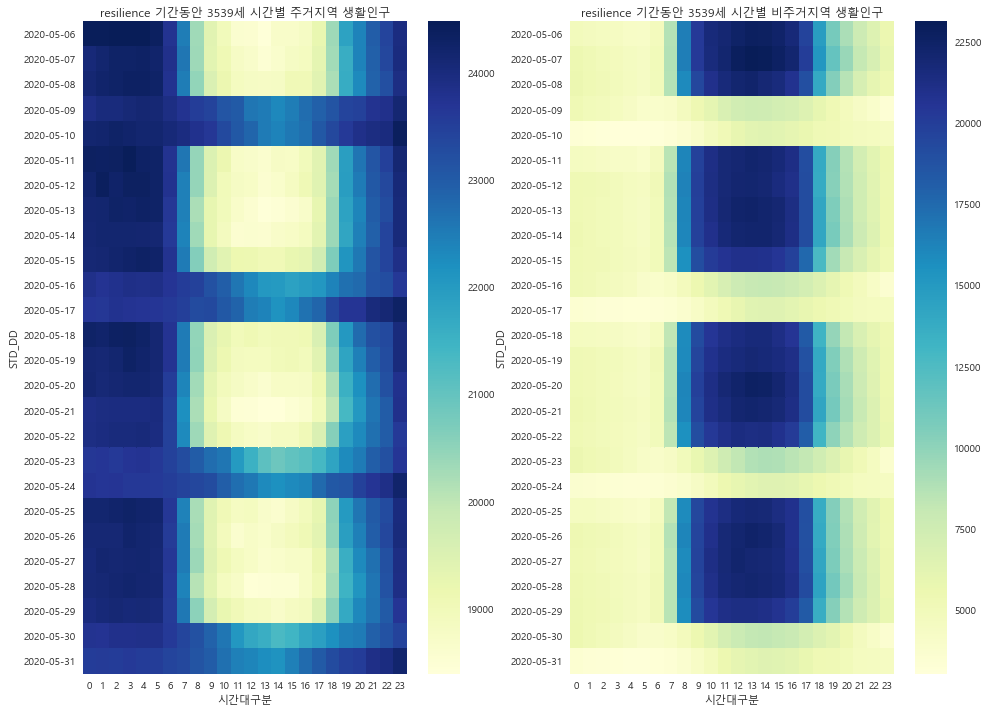

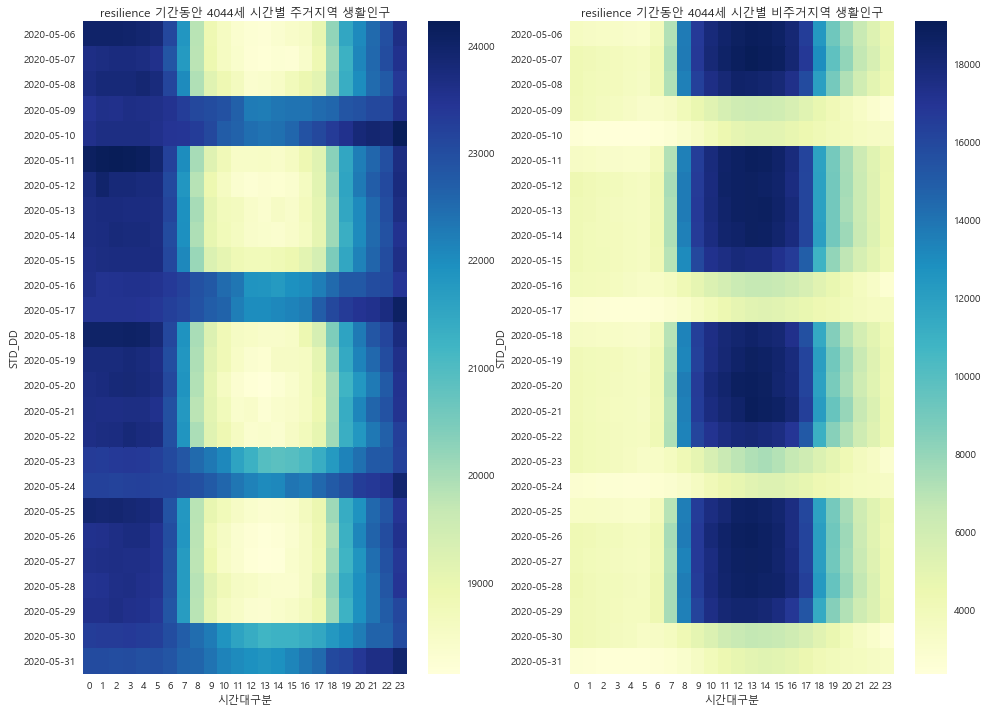

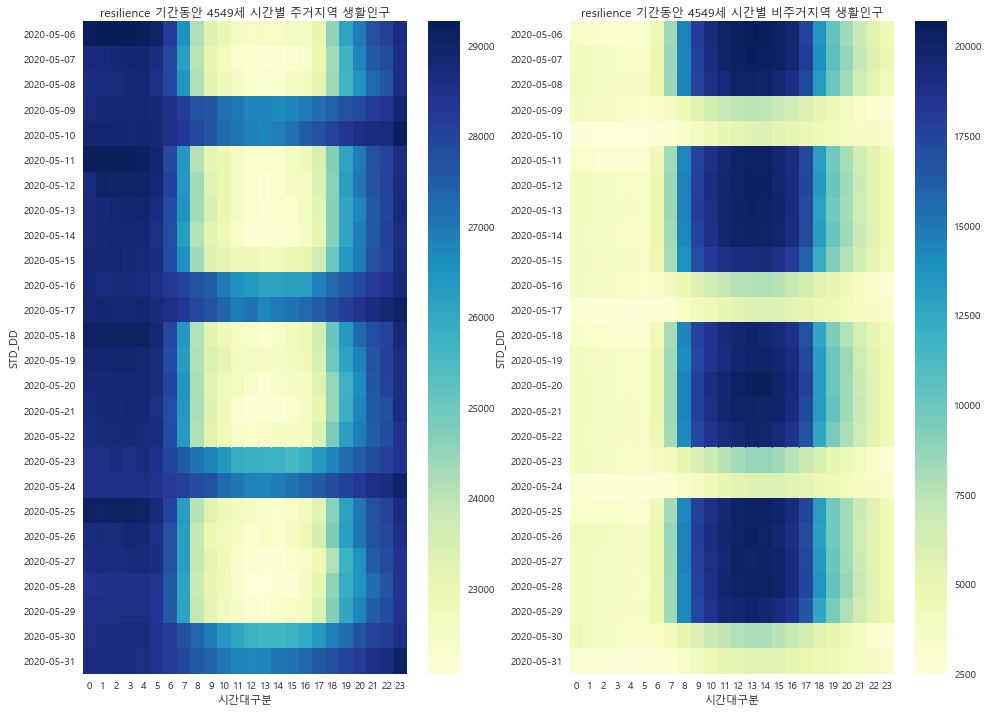

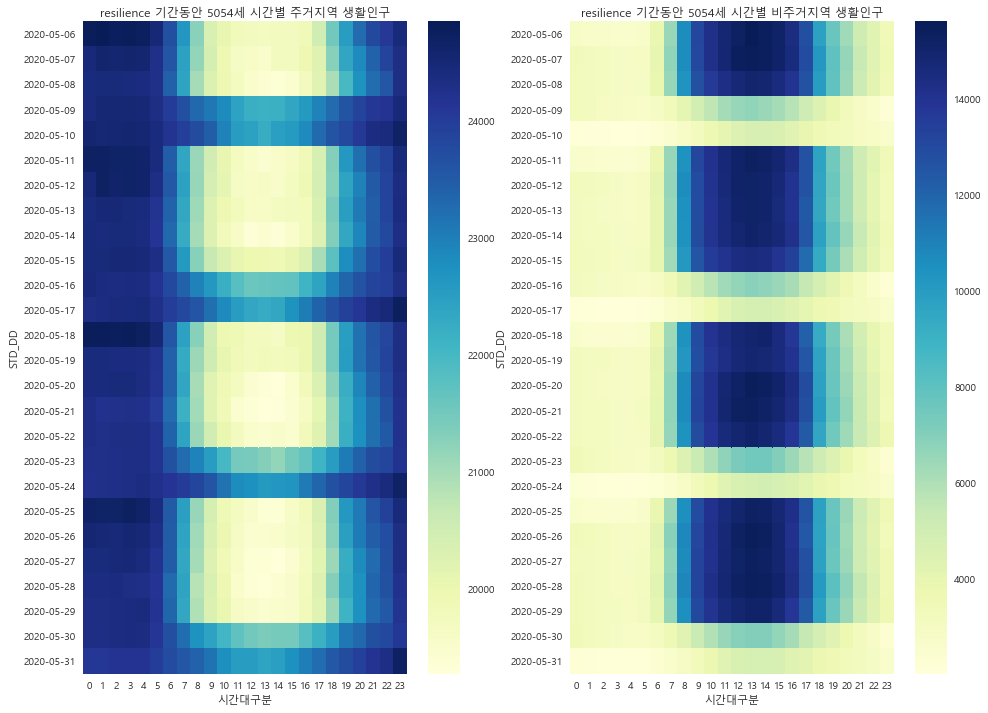

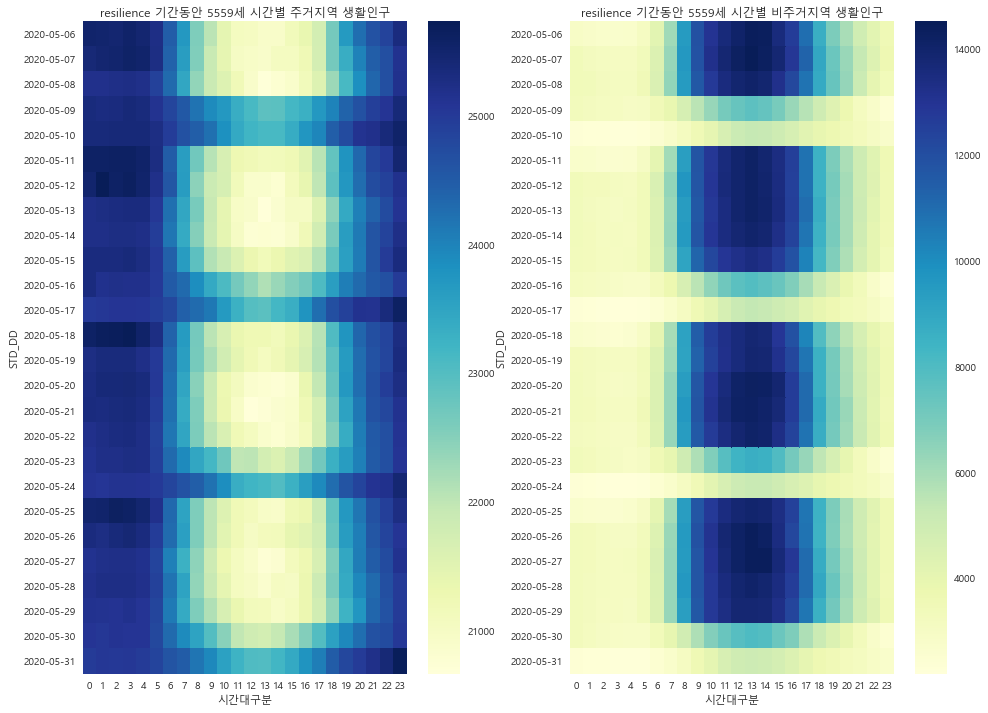

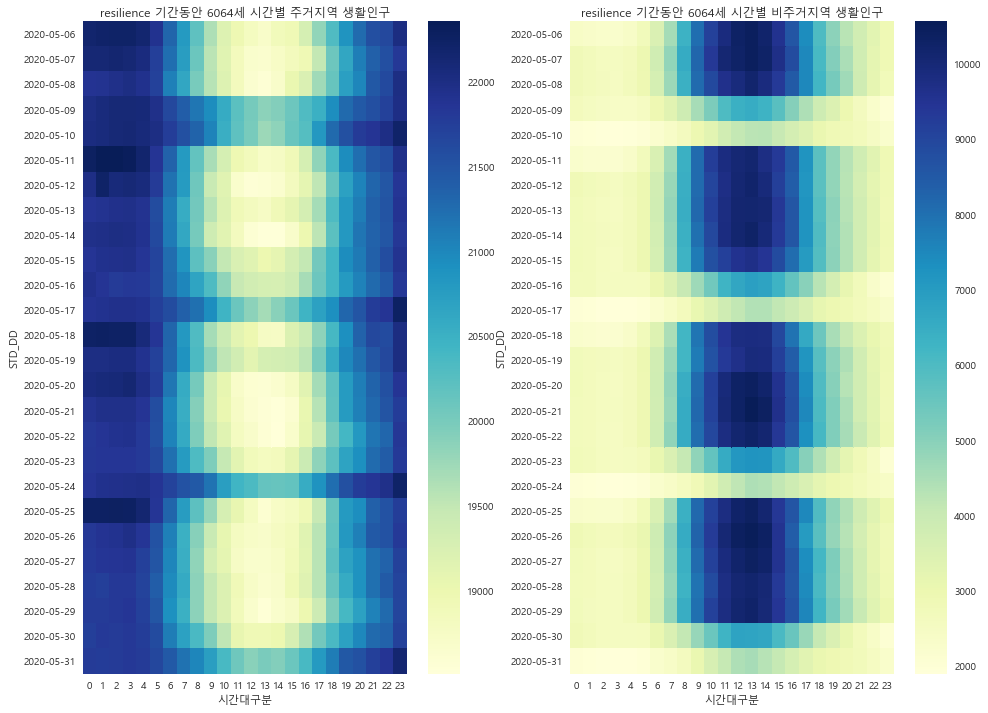

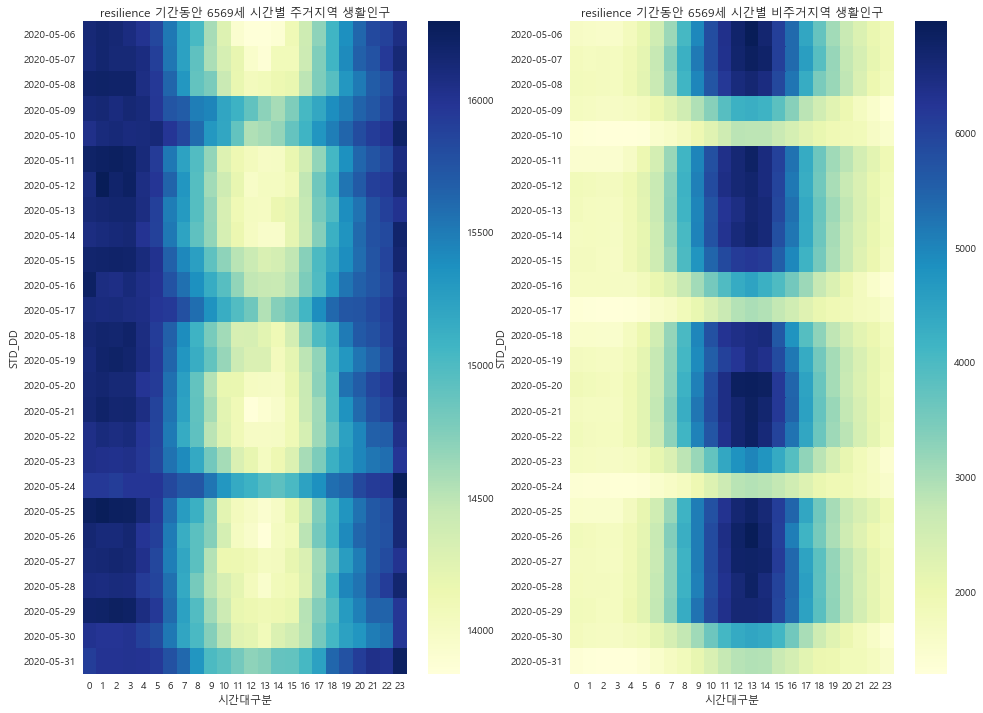

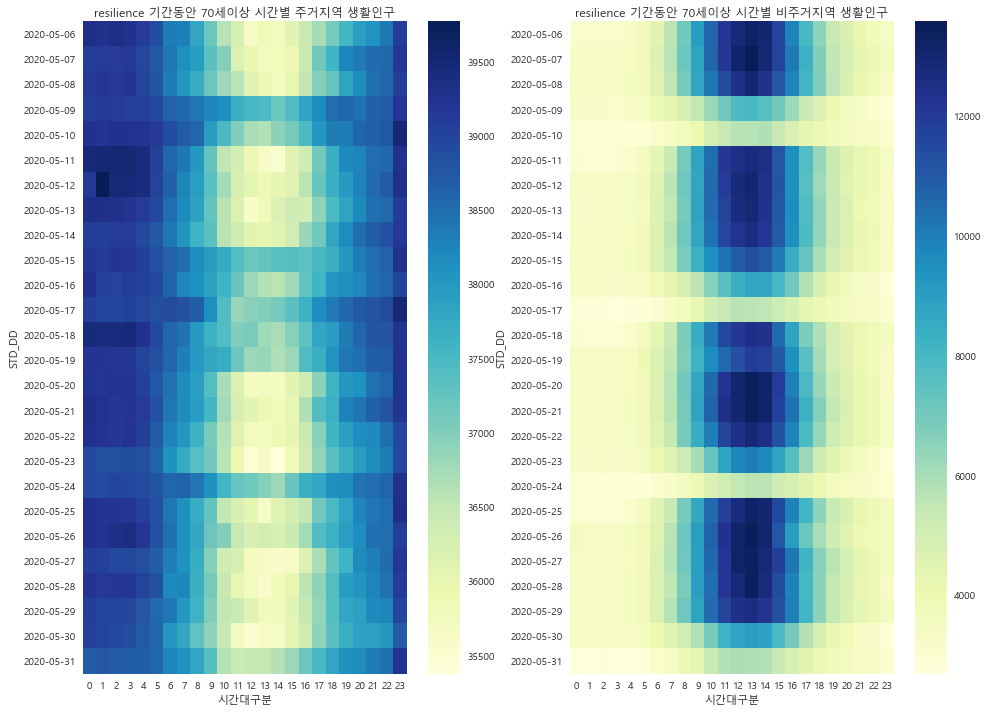

In [35]:
rnr_category_time_with_period_graph(dfdf,'resilience','AGE_CD')

### Line Graph

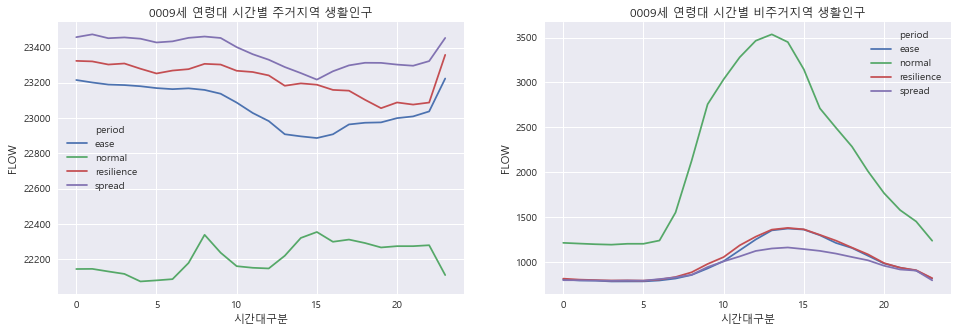

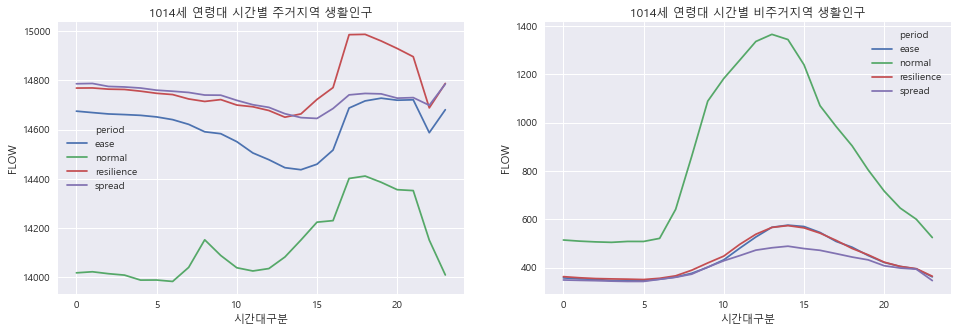

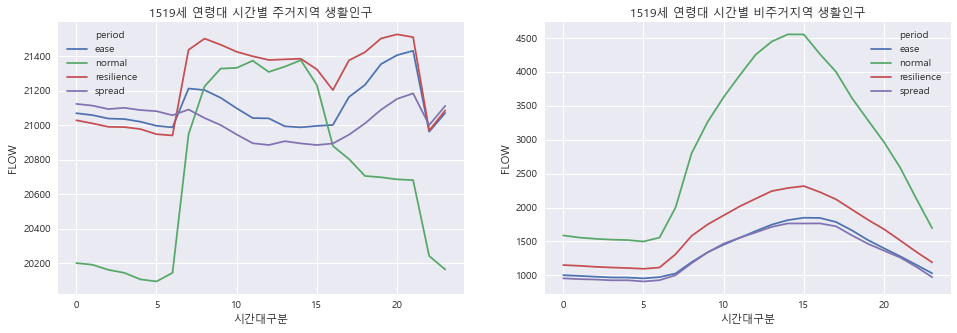

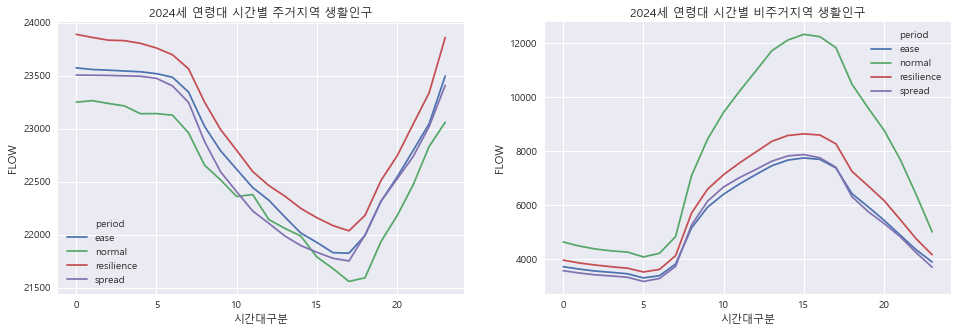

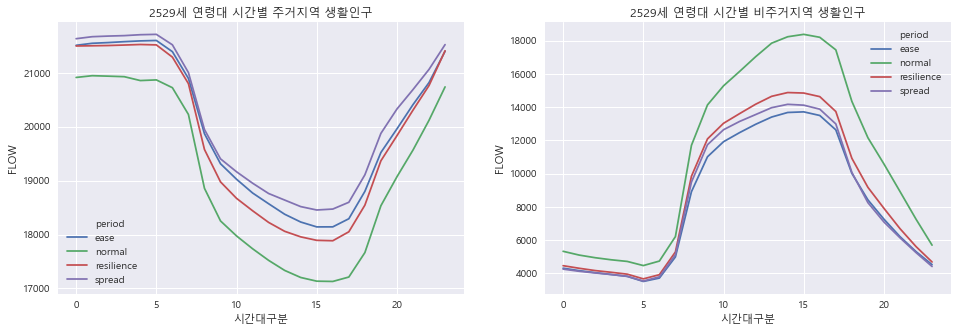

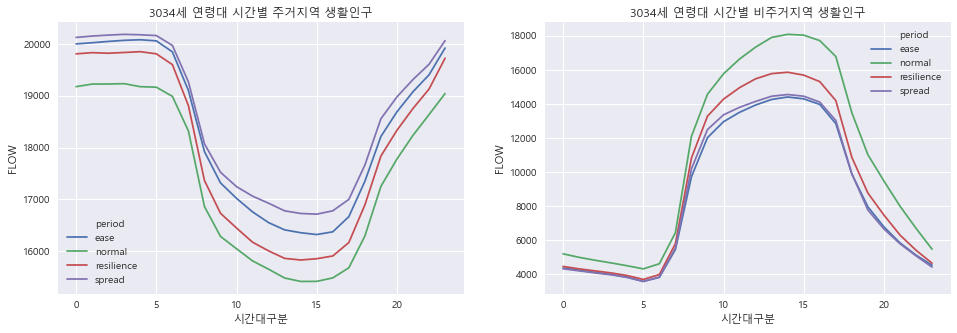

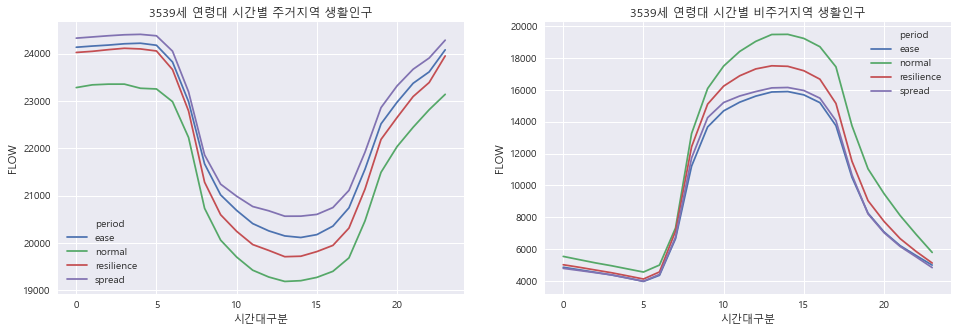

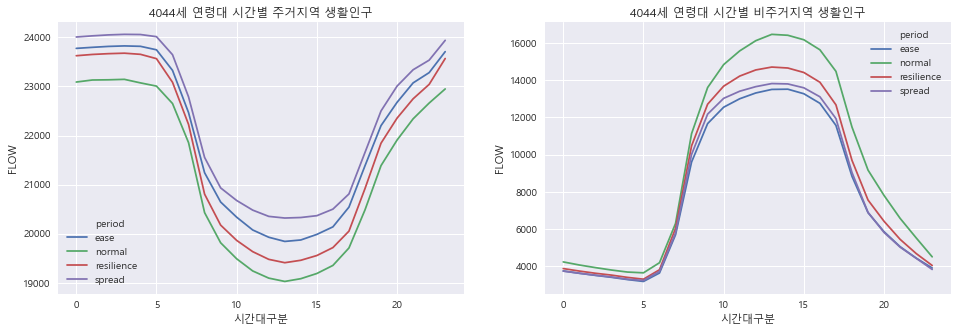

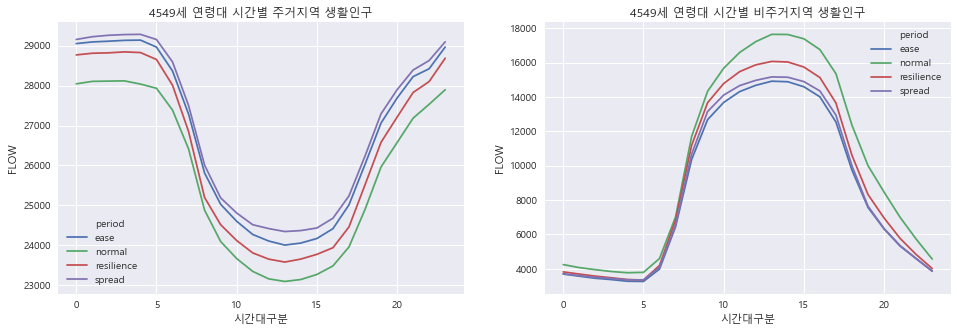

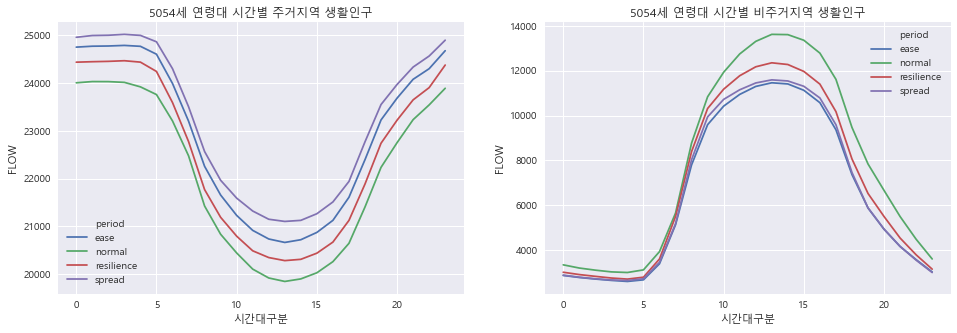

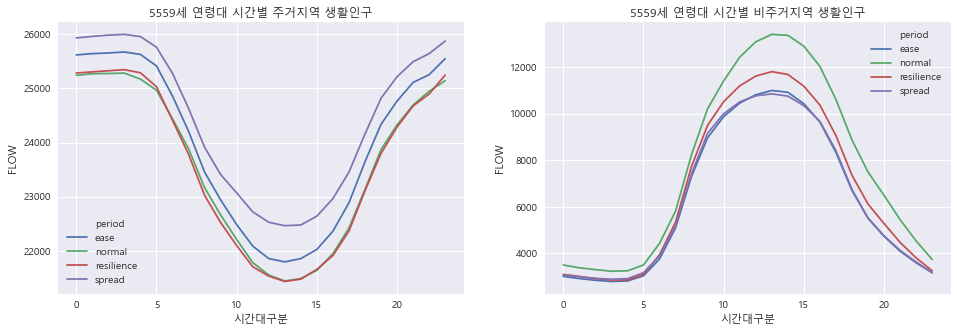

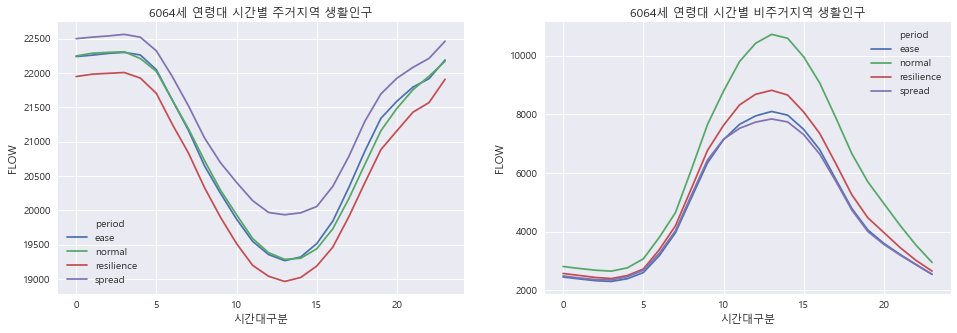

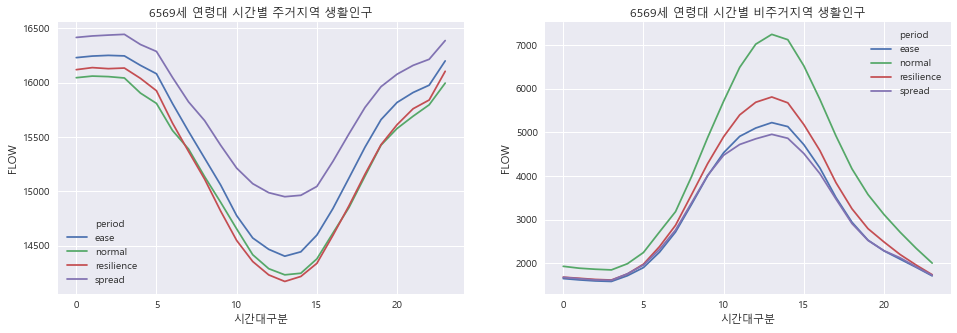

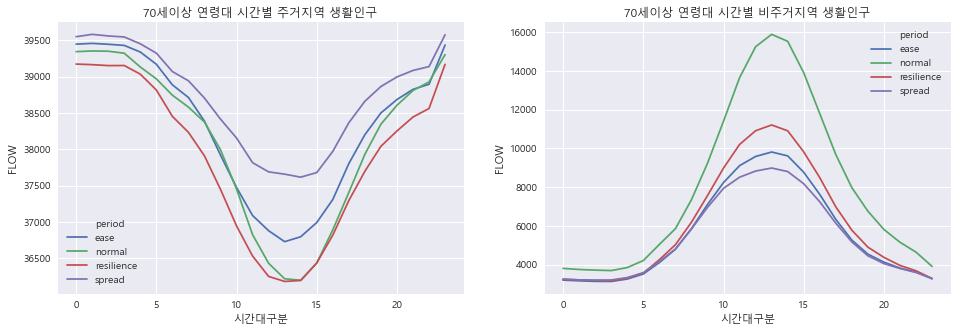

In [36]:
r = dfdf.query('resident == 1').groupby(['시간대구분','AGE_CD','period','HDONG_NM'])[['FLOW']].mean().reset_index()
r = r.groupby(['시간대구분','AGE_CD','period'])[['FLOW']].sum().reset_index()
nr = dfdf.query('resident == 0').groupby(['시간대구분','AGE_CD','period','HDONG_NM'])[['FLOW']].mean().reset_index()
nr = nr.groupby(['시간대구분','AGE_CD','period'])[['FLOW']].sum().reset_index()
for age in dfdf['AGE_CD'].unique():
    fig, axes = plt.subplots(ncols=2, figsize=(16, 5))
    sns.lineplot(data=r.query('AGE_CD == "{}"'.format(age)),x='시간대구분',y='FLOW',hue='period',ax=axes[0])
    axes[0].set_title('{} 연령대 시간별 주거지역 생활인구'.format(age))
    sns.lineplot(data=nr.query('AGE_CD == "{}"'.format(age)),x='시간대구분',y='FLOW',hue='period',ax=axes[1])
    axes[1].set_title('{} 연령대 시간별 비주거지역 생활인구'.format(age))

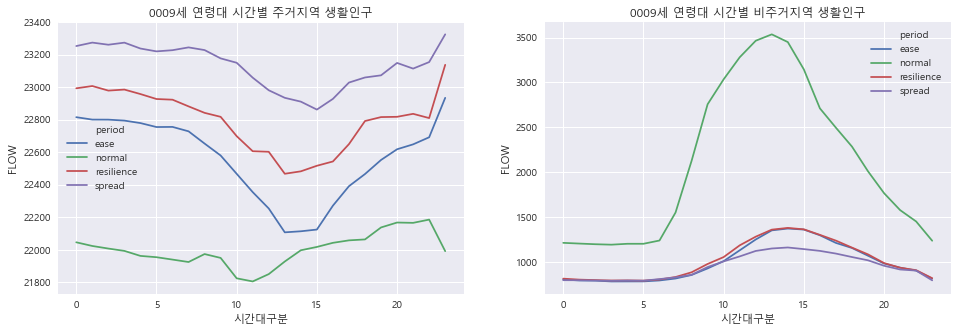

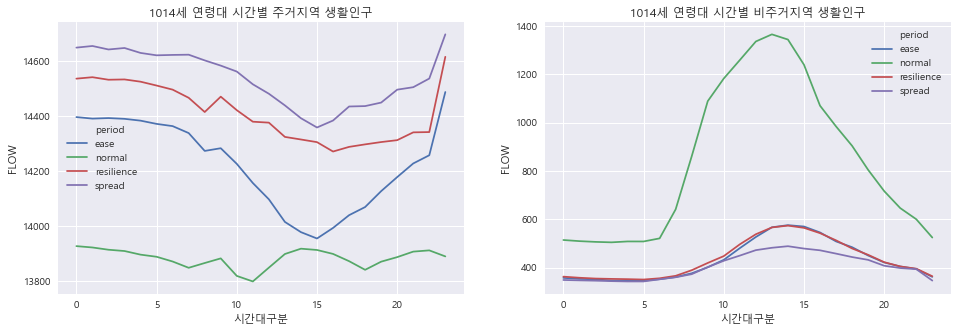

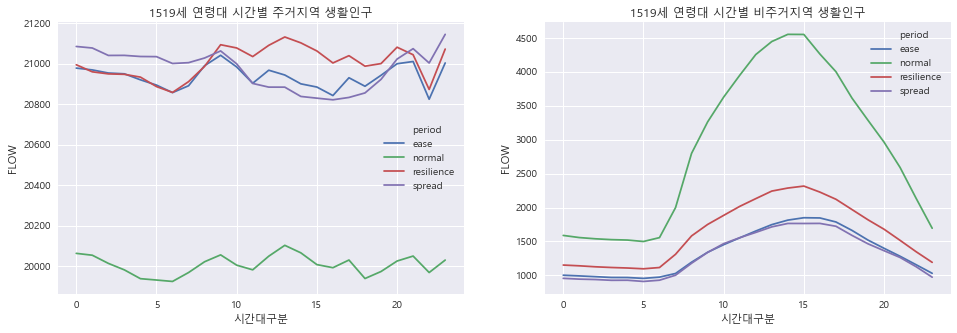

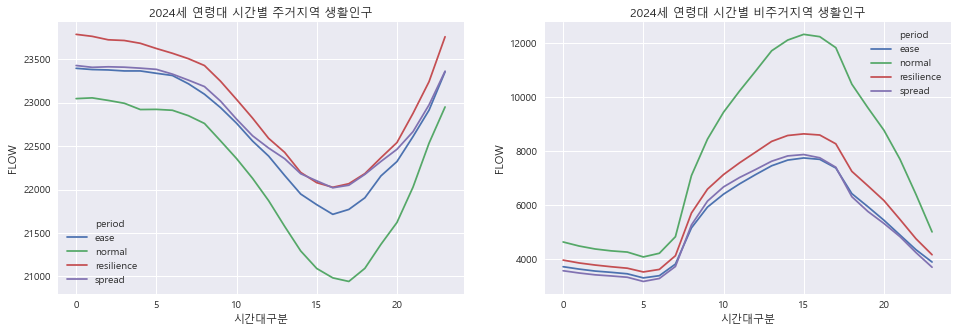

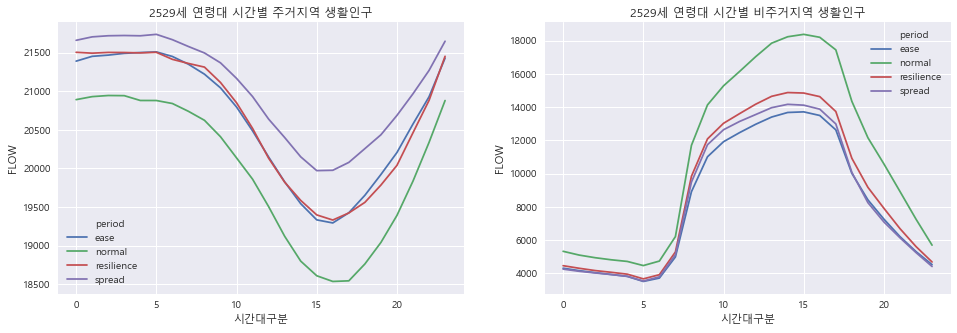

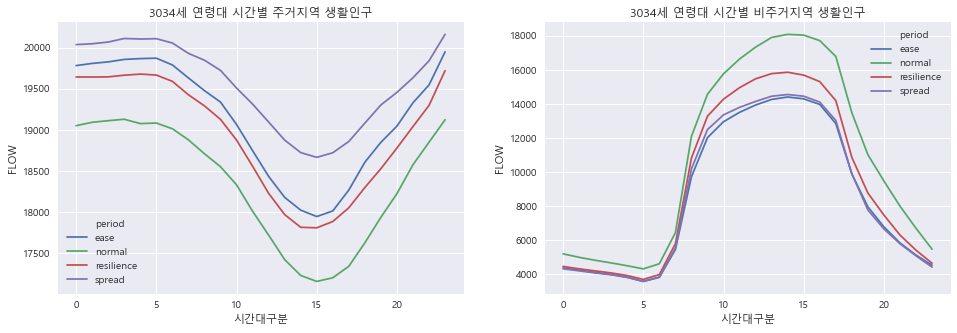

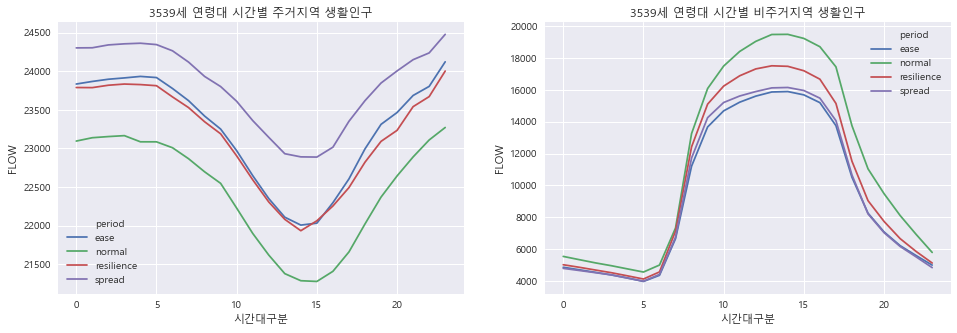

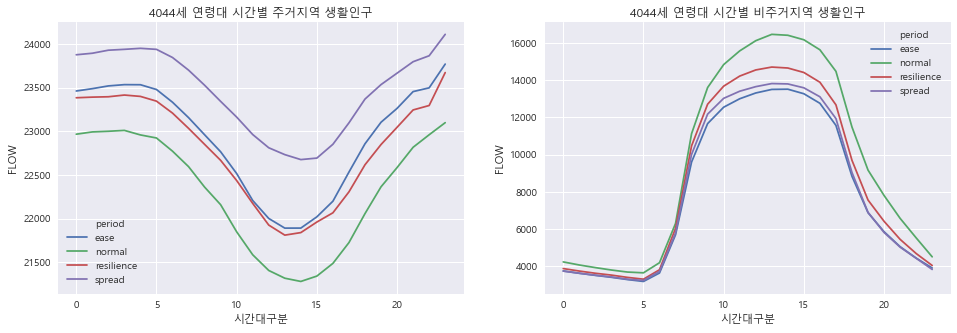

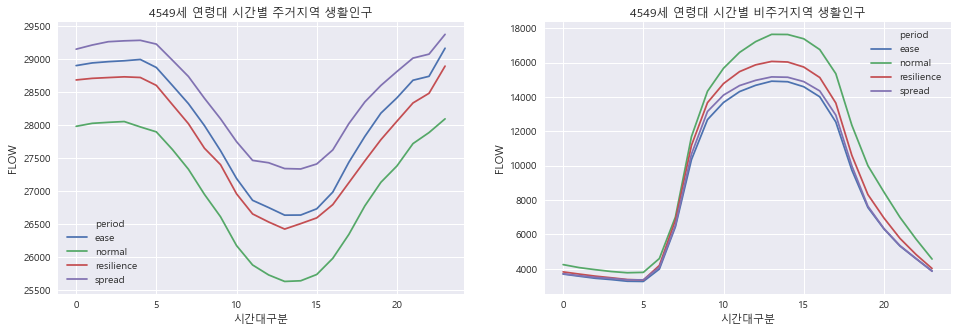

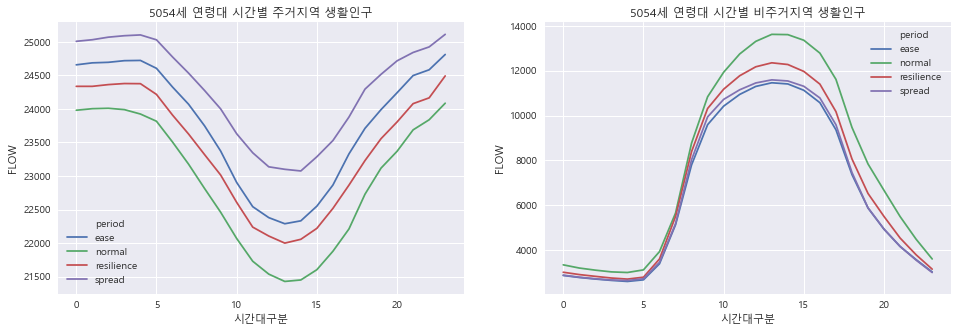

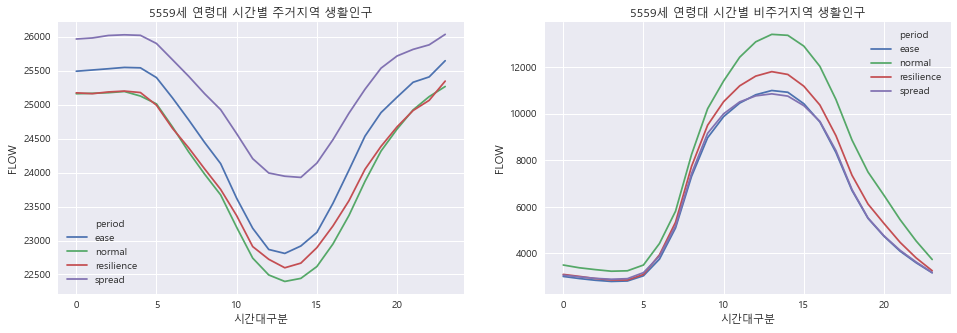

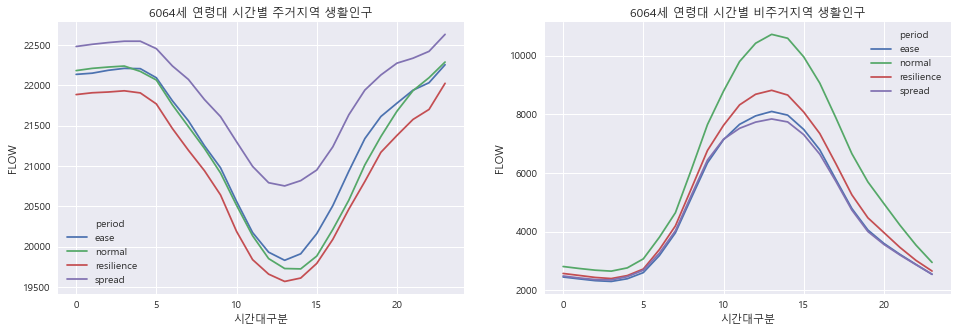

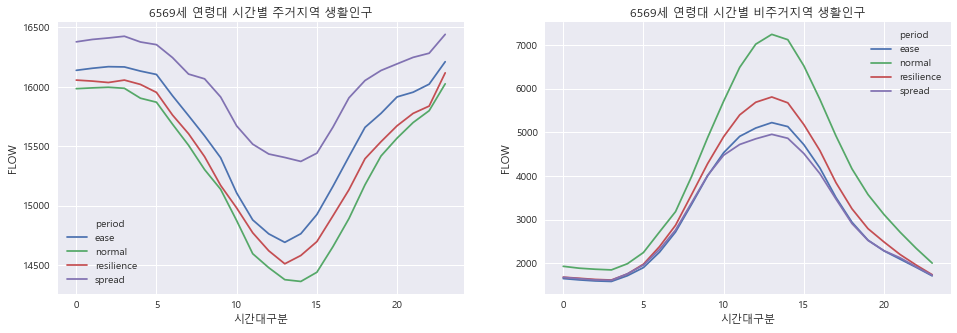

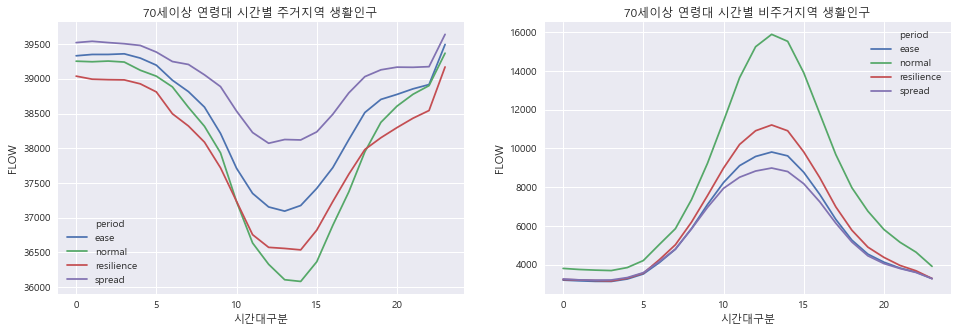

In [37]:
r = dfdf[(dfdf['WEEKDAY'].str.endswith('토')) | (dfdf['WEEKDAY'].str.endswith('일'))].query('resident == 1').groupby(['시간대구분','AGE_CD','period','HDONG_NM'])[['FLOW']].mean().reset_index()
r = r.groupby(['시간대구분','AGE_CD','period'])[['FLOW']].sum().reset_index()
nr = dfdf.query('resident == 0').groupby(['시간대구분','AGE_CD','period','HDONG_NM'])[['FLOW']].mean().reset_index()
nr = nr.groupby(['시간대구분','AGE_CD','period'])[['FLOW']].sum().reset_index()
for age in dfdf['AGE_CD'].unique():
    fig, axes = plt.subplots(ncols=2, figsize=(16, 5))
    sns.lineplot(data=r.query('AGE_CD == "{}"'.format(age)),x='시간대구분',y='FLOW',hue='period',ax=axes[0])
    axes[0].set_title('{} 연령대 시간별 주거지역 생활인구'.format(age))
    sns.lineplot(data=nr.query('AGE_CD == "{}"'.format(age)),x='시간대구분',y='FLOW',hue='period',ax=axes[1])
    axes[1].set_title('{} 연령대 시간별 비주거지역 생활인구'.format(age))

In [38]:
def age_period_rpeople_with_period(age):
    temp = dfdf.query('resident == 1').query('AGE_CD == "{}"'.format(age)).groupby(['HDONG_NM','WEEKDAY','시간대구분','period'])[['FLOW']].mean()
    temp = temp.groupby(['WEEKDAY','시간대구분','period'])[['FLOW']].sum().reset_index()

    for i in temp['WEEKDAY'].unique():
        t = temp.loc[temp['WEEKDAY'] == i,:]
        sns.relplot(data=t,x='시간대구분',y='FLOW',hue='period',kind='line',size=4,aspect=3)
        plt.title('{} 요일 시기별 주거지역 생활인구'.format(i),fontsize=15)

        plt.show()

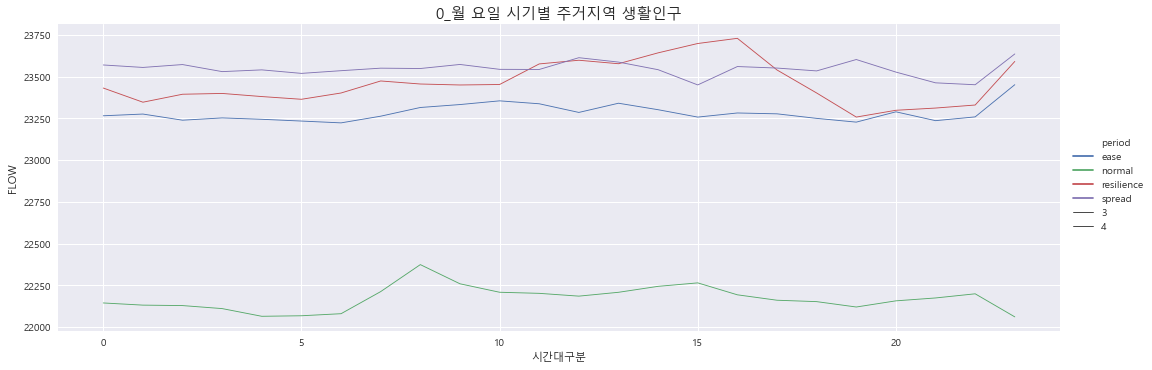

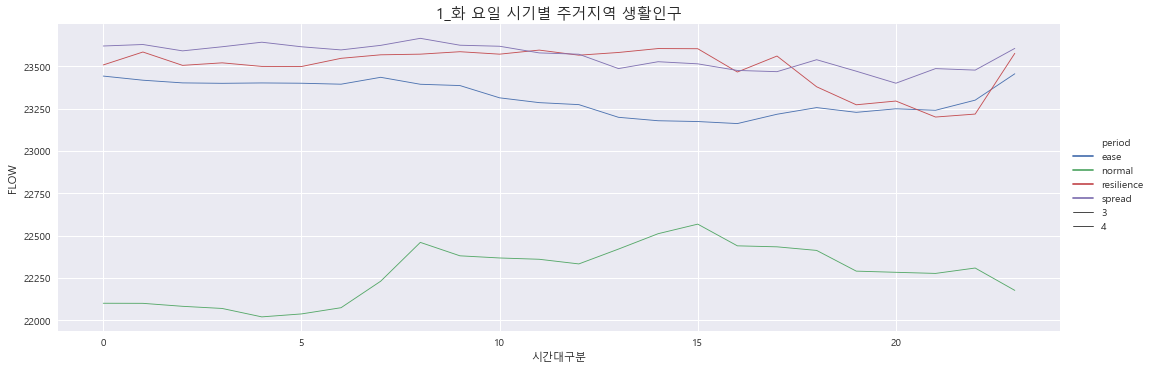

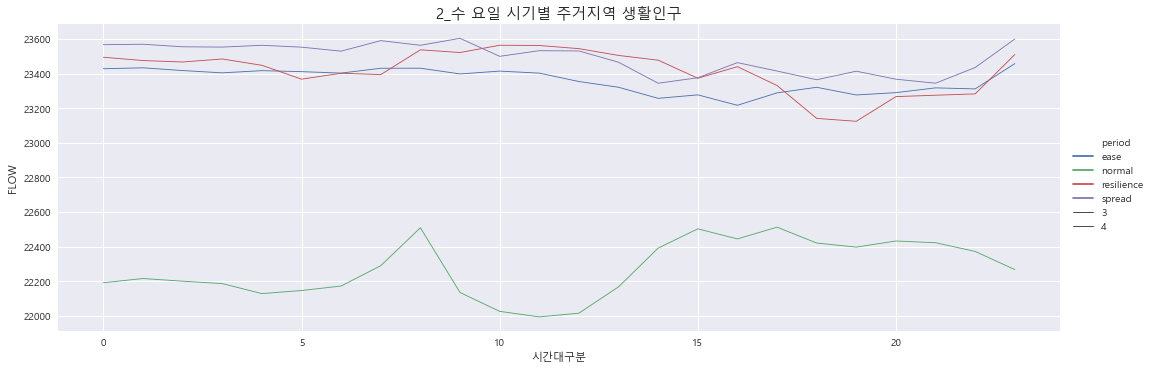

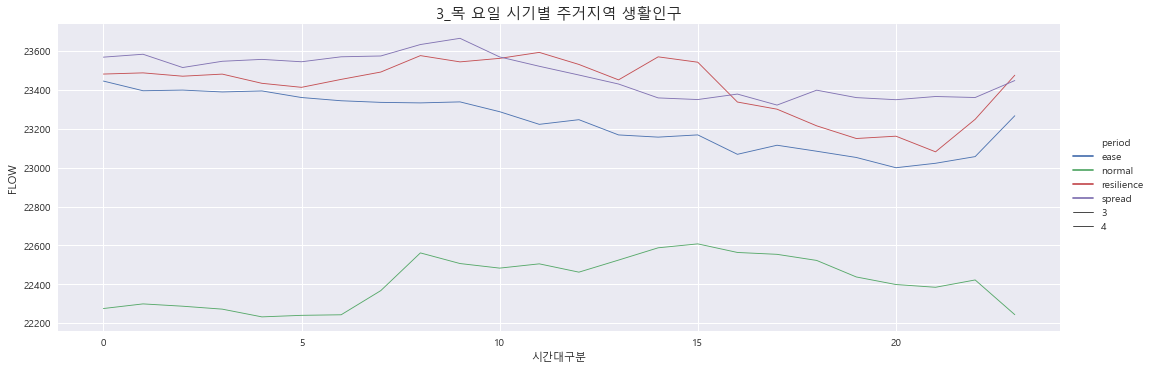

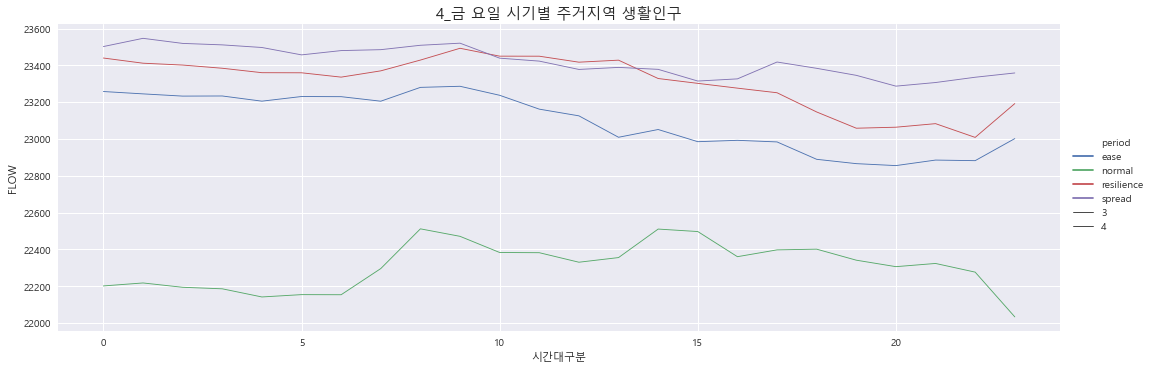

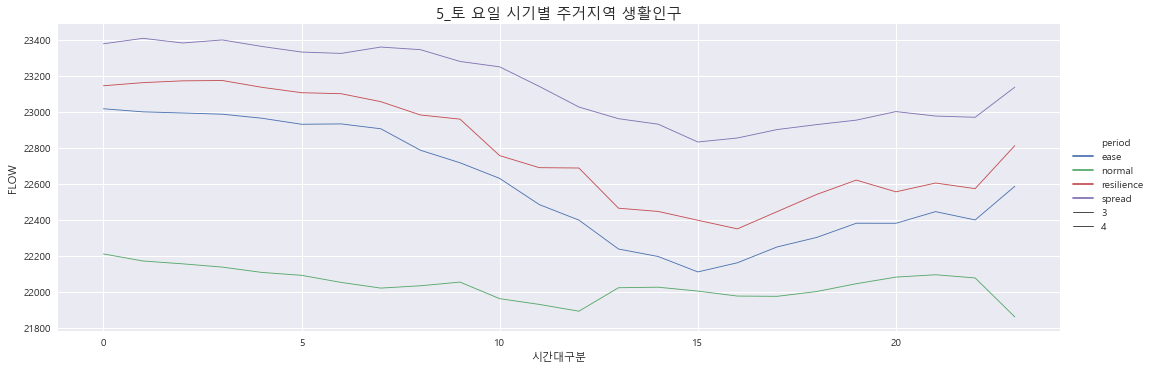

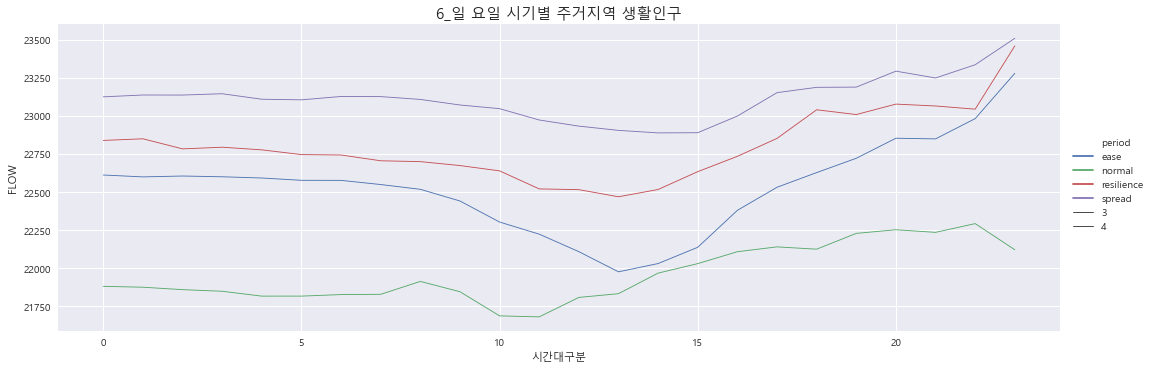

In [39]:
age_period_rpeople_with_period('0009세') 
# 화~목요일만 ease, spread 시기 때 시간대 생활인구가 엎치락 뒤치락 함
## 1014세 요일별 주거지역 생활인구도 이와 비슷한 패턴

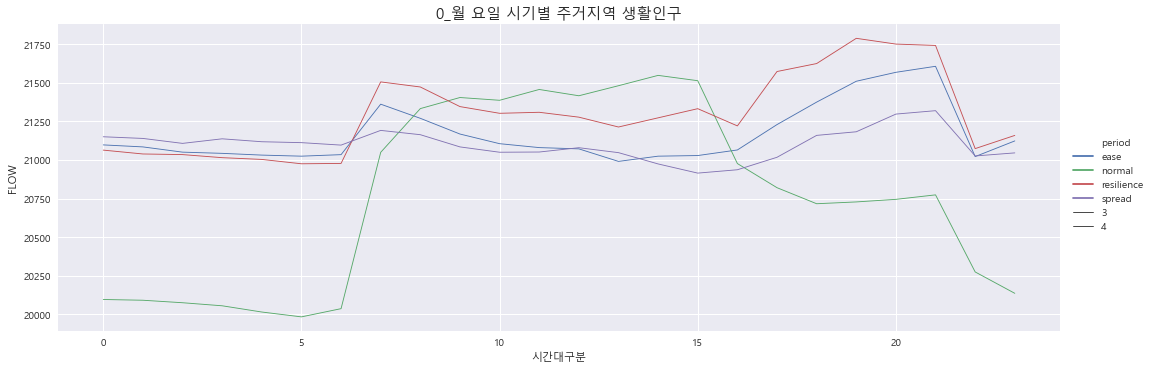

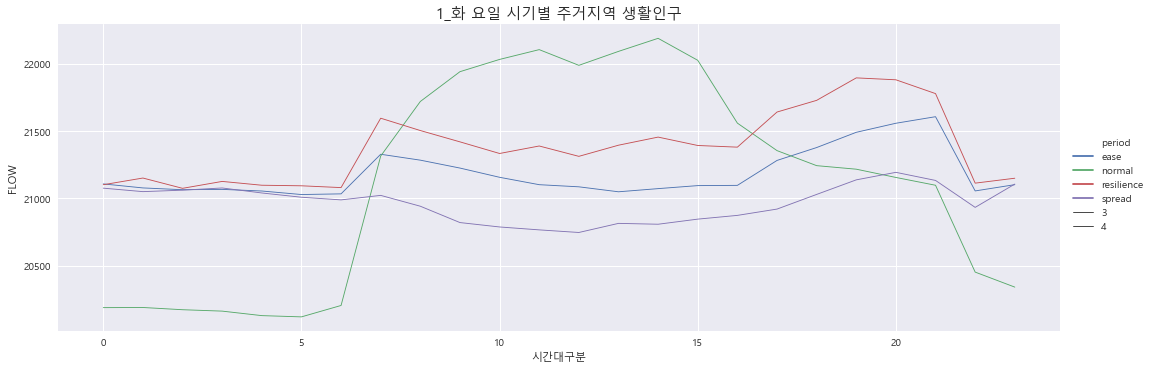

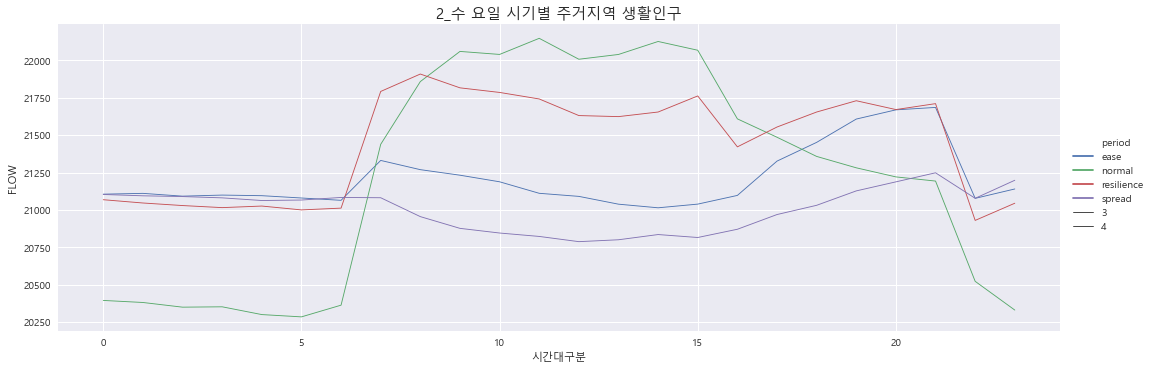

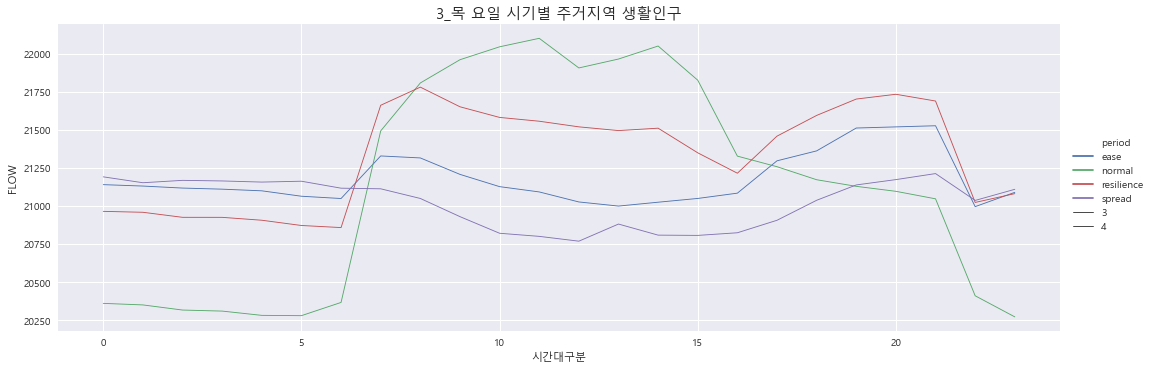

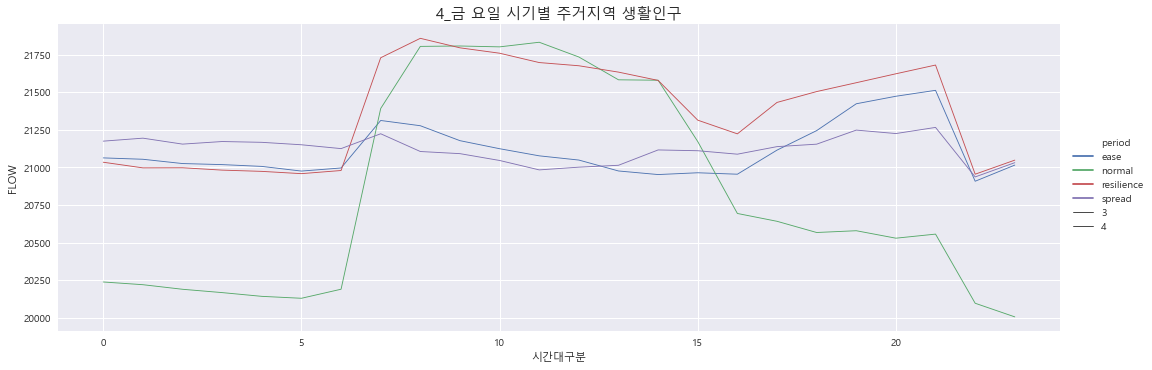

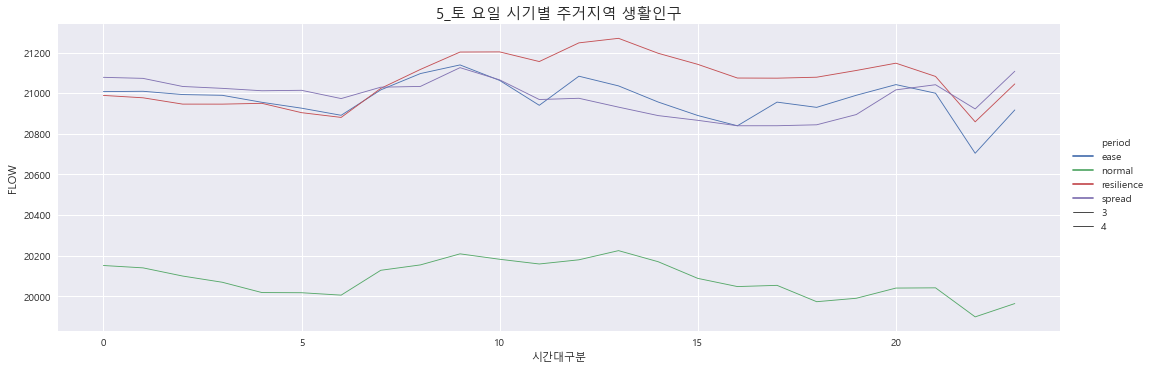

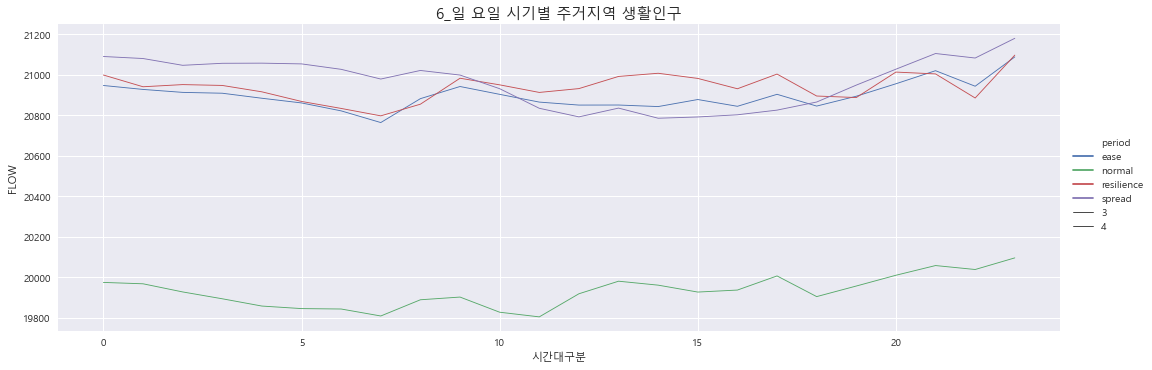

In [40]:
age_period_rpeople_with_period('1519세')
#normal 시기에 낮 시간대 생활인구 반짝 증가는 학교 때문인 것으로 추정(평일에 이 패턴이 나오기 때문)
## 해당 연령대 생활인구는 코로나 이전 시기 주말에 주거지역에 많이 없음

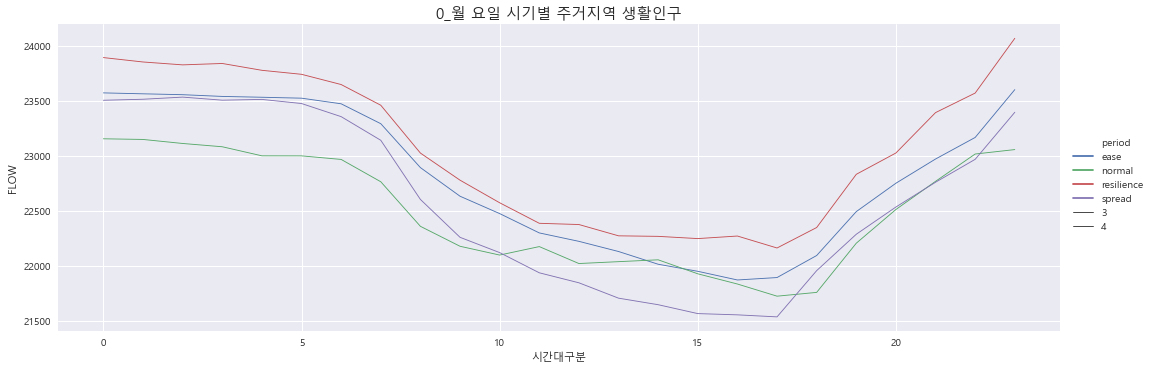

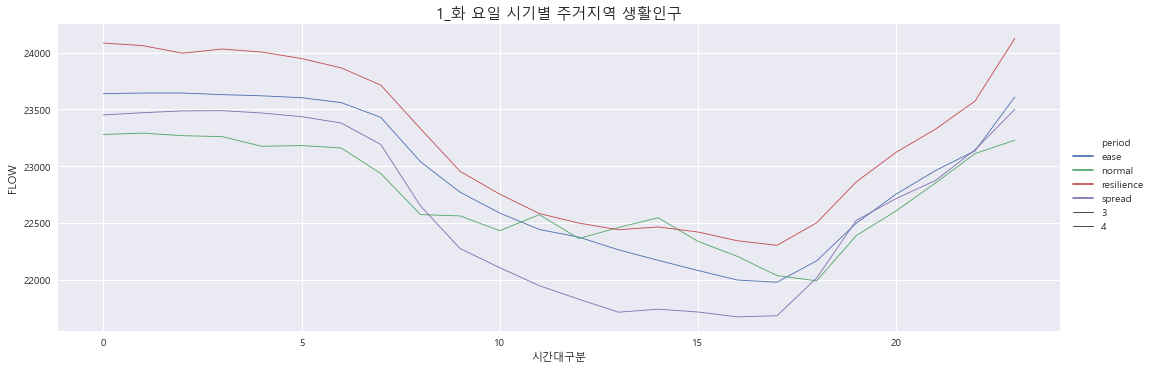

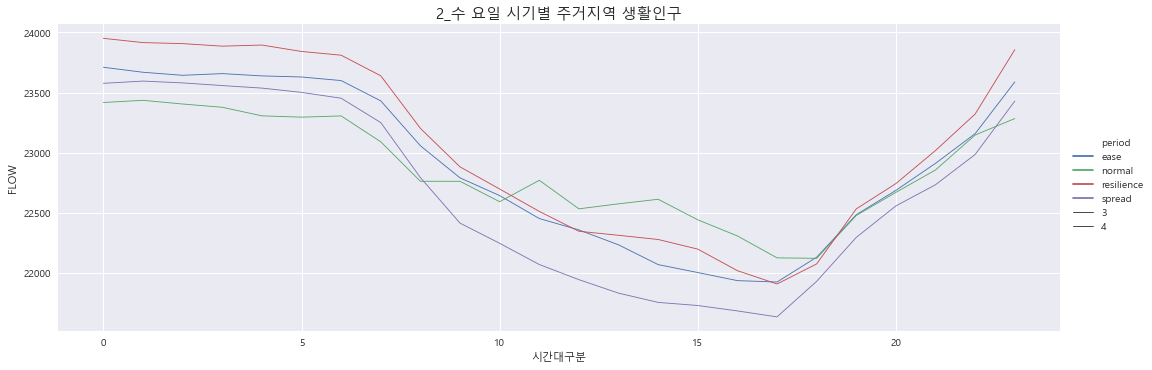

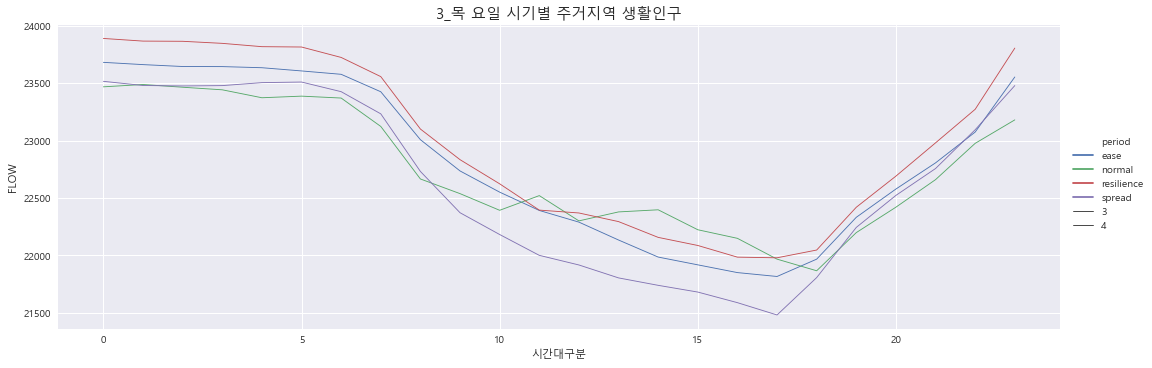

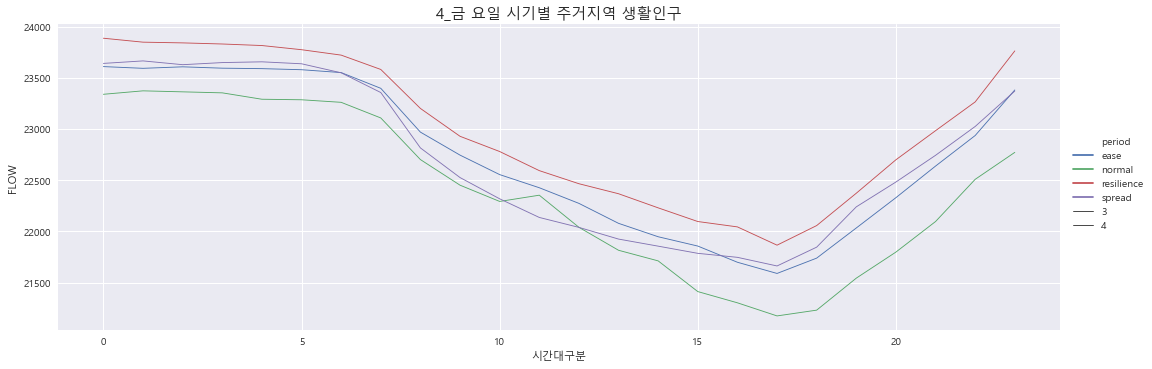

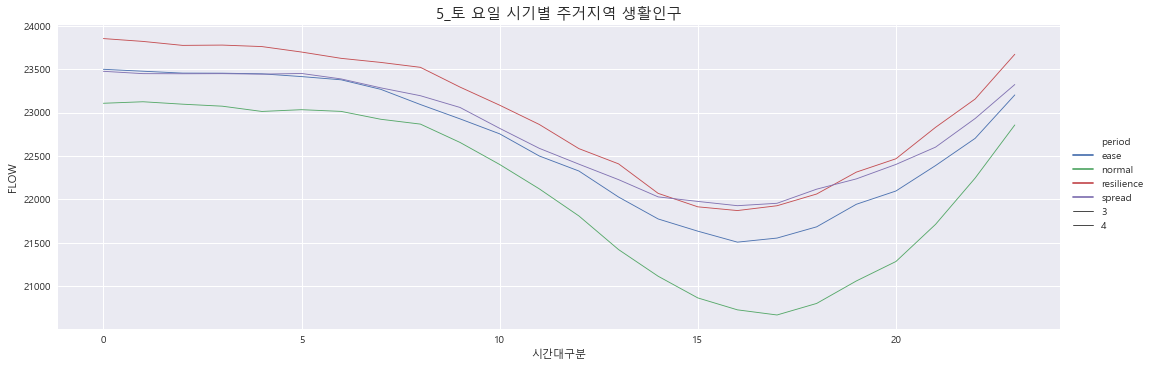

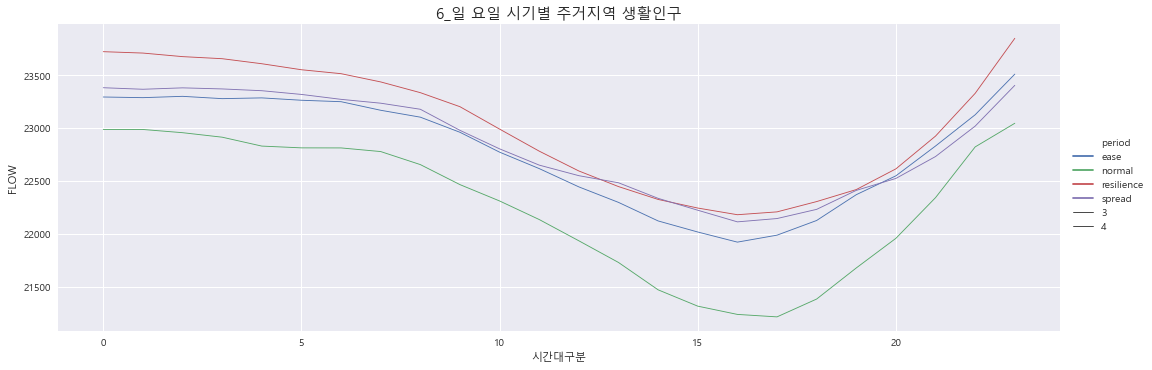

In [41]:
age_period_rpeople_with_period('2024세')

# 관광지역과 비관광지역

In [42]:
tourism = dfdf.query('tourism == 1').reset_index(drop=True)
non_tourism = dfdf.query('tourism == 0').reset_index(drop=True)

## 시간 X 코로나 기간(요일별)

#### 관광지역과 비관광지역의 요일별 생활인구
* 관광지역과 비관광지역 모두 평일에는 낮 시간대에 생활인구가 많음<br>
* 관광지역은 주말에는 낮 시간대 중에서도 특히 점심 즈음에 생활인구가 두드러지게 많음<br>
* 비관광지역은 주말에는 낮 시간대에 생활인구가 적다 : 확산기>(완화)>회복기>평소<br>
* 비관광지역에서 평소시기보다 코로나 확산시기, 완화시기에 생활인구가 높음 -> **이것이 사람들이 관광지에 방문하지 않았다는 반증이 될 수 있는가?(줄어든 것은 맞지만 역이 성립하는지는 의문)** <br>
* 관광지역 : 비거주지역 생활인구의 양상과 비슷한데, 서울의 경우 비거주지역(혹은 사무지역)과 관광지역이 일치하는 경우가 많기 때문에 그런 듯.

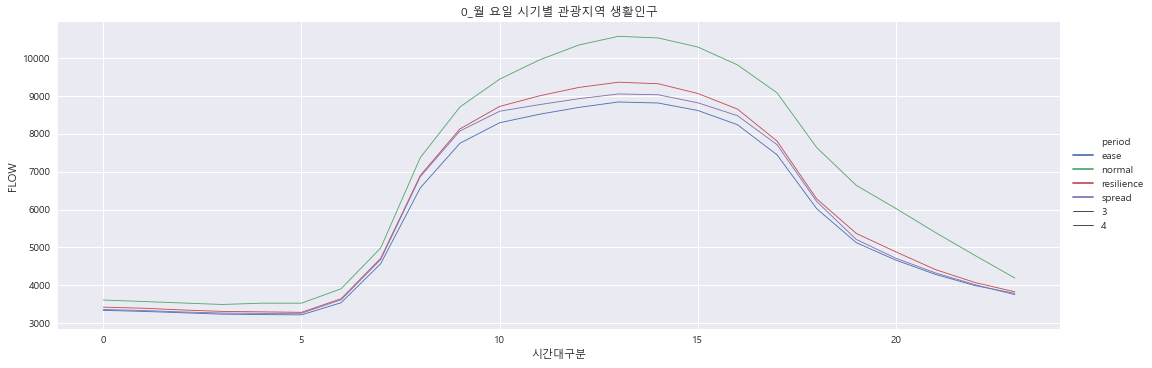

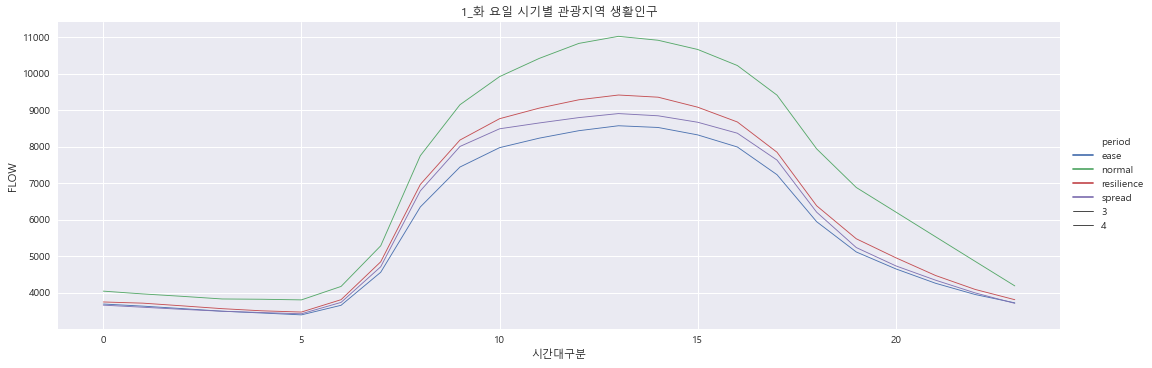

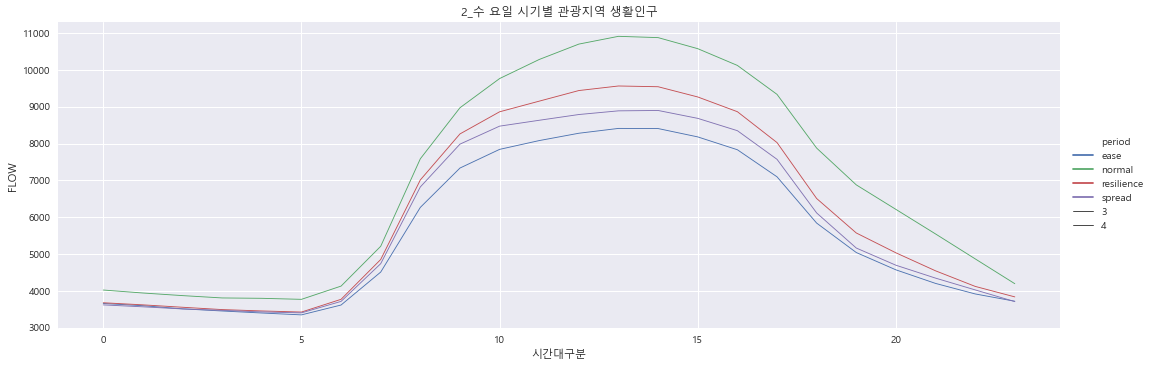

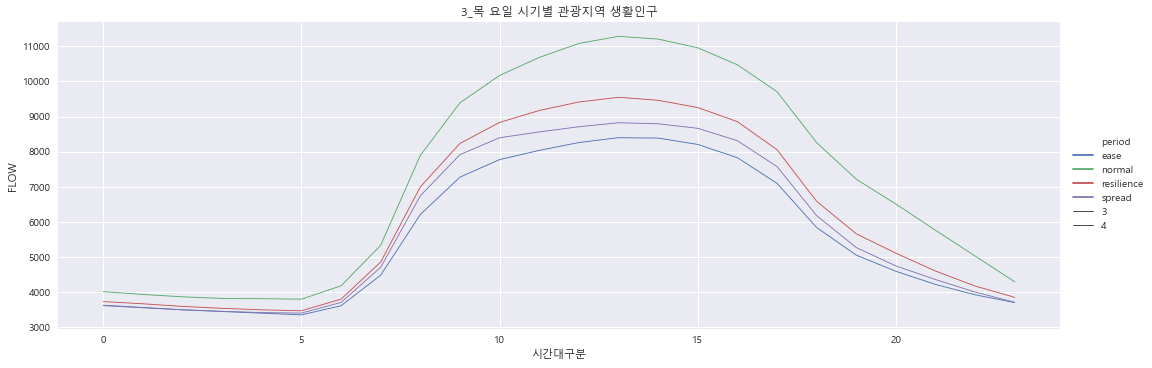

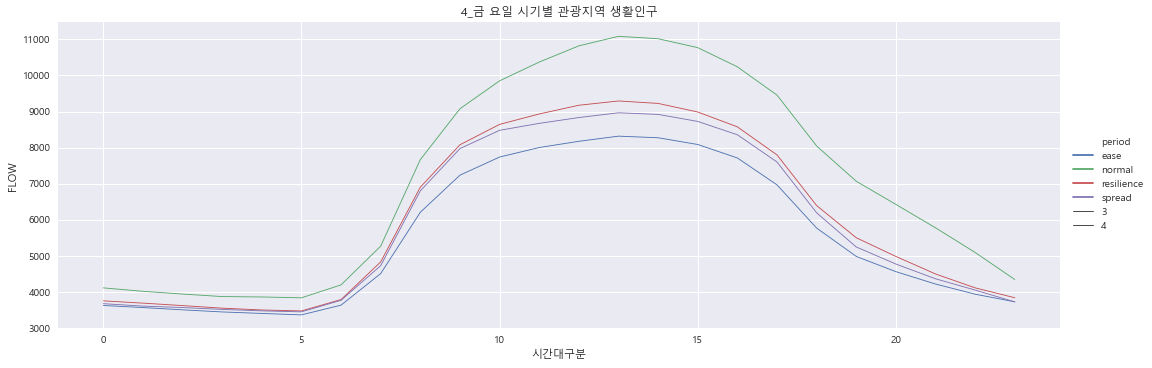

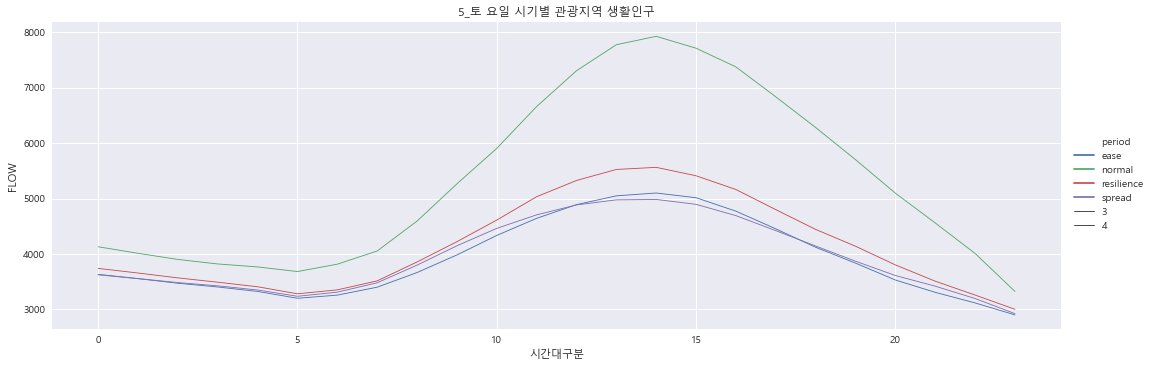

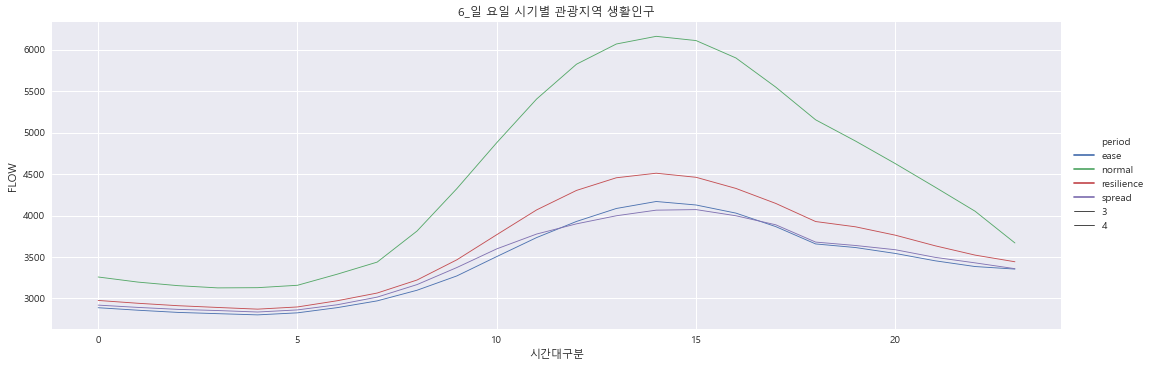

In [43]:
temp = tourism.groupby(['HDONG_NM','WEEKDAY','시간대구분','period'])[['FLOW']].mean()
temp = temp.groupby(['WEEKDAY','시간대구분','period'])[['FLOW']].sum().reset_index()
for i in temp['WEEKDAY'].unique():
    t = temp.loc[temp['WEEKDAY'] == i,:]
    ax = sns.relplot(data=t,x='시간대구분',y='FLOW',hue='period',kind='line',size=4,aspect=3)
    plt.title('{} 요일 시기별 관광지역 생활인구'.format(i))
    plt.show()

In [ ]:
temp = non_tourism.groupby(['HDONG_NM','WEEKDAY','시간대구분','period'])[['FLOW']].mean()
temp = temp.groupby(['WEEKDAY','시간대구분','period'])[['FLOW']].sum().reset_index()
for i in temp['WEEKDAY'].unique():
    t = temp.loc[temp['WEEKDAY'] == i,:]
    ax = sns.relplot(data=t,x='시간대구분',y='FLOW',hue='period',kind='line',size=4,aspect=3)
    plt.title('{} 요일 시기별 비관광지역 생활인구'.format(i))
    plt.show()

## 시간 X 연령 X 코로나 기간

#### 관광지역과 비관광지역 간 차이
* 관광지역 : 70세 이상 연령대를 제외하고 연령이 많아질수록(70세 이상에서 요일별 큰 패턴 차이는 없었음) 관광지역의 생활인구 최대치 감소 => 전체적으로 코로나 이전 시기보다 코로나 이후 시기의 생활인구가 많이 감소했기 때문에, 요일별 그래프로 보아도 대부분 연령대에서 시간별 차이가 없음
* 중장년층 : 중장년층은 다른 연령대에 비해 평소 수준과 생활인구의 차이가 적음
* 서울의 경우 관광지역은 보통 사무지역과 같이 있는 경우가 많아 생활인구의 패턴이 사무지역과 비슷함 => 대구는 상황이 다를 수도 있음

### Heatmap

In [ ]:
def tnt_category_time_with_period_graph(data, period, category):
    t_df = data.query('tourism == 1')
    t_df = t_df.query('period in "{}"'.format(period)).groupby(['STD_DD','HDONG_NM','시간대구분',category])[['FLOW']].mean().reset_index()
    t_df = t_df.groupby(['STD_DD','시간대구분',category])[['FLOW']].sum().reset_index()
    f_df = data.query('tourism == 0')
    f_df = f_df.query('period in "{}"'.format(period)).groupby(['STD_DD','HDONG_NM','시간대구분',category])[['FLOW']].mean().reset_index()
    f_df = f_df.groupby(['STD_DD','시간대구분',category])[['FLOW']].sum().reset_index()
    
    for i in data[category].unique():
        fig, axes = plt.subplots(ncols=2, figsize=(16, 12))
        r = t_df.query('{} == "{}"'.format(category, i))[['STD_DD','시간대구분','FLOW']]
        nr = f_df.query('{} == "{}"'.format(category, i))[['STD_DD','시간대구분','FLOW']]
        r = pd.pivot_table(r,index='STD_DD',columns='시간대구분',values='FLOW')
        nr = pd.pivot_table(nr,index='STD_DD',columns='시간대구분',values='FLOW')
        sns.heatmap(r,cmap='YlGnBu',ax=axes[0])
        axes[0].set_title('{} 기간동안 {} 시간별 관광지역 생활인구'.format(period,i))
        sns.heatmap(nr,cmap='YlGnBu',ax=axes[1])
        axes[1].set_title('{} 기간동안 {} 시간별 비관광지역 생활인구'.format(period,i))
        plt.show()

In [ ]:
tnt_category_time_with_period_graph(dfdf,'normal','AGE_CD')

In [ ]:
tnt_category_time_with_period_graph(dfdf,'spread','AGE_CD')

In [ ]:
tnt_category_time_with_period_graph(dfdf,'resliance','AGE_CD')

### Line Graph

In [ ]:
r = dfdf.query('tourism == 1').groupby(['시간대구분','AGE_CD','period','HDONG_NM'])[['FLOW']].mean().reset_index()
r = r.groupby(['시간대구분','AGE_CD','period'])[['FLOW']].sum().reset_index()
nr = dfdf.query('tourism == 0').groupby(['시간대구분','AGE_CD','period','HDONG_NM'])[['FLOW']].mean().reset_index()
nr = nr.groupby(['시간대구분','AGE_CD','period'])[['FLOW']].sum().reset_index()
for age in age_gr['AGE_CD'].unique():
    fig, axes = plt.subplots(ncols=2, figsize=(16, 5))
    sns.lineplot(data=r.query('AGE_CD == "{}"'.format(age)),x='시간대구분',y='FLOW',hue='period',ax=axes[0])
    axes[0].set_title('{} 연령대 시간별 관광지역 생활인구'.format(age))
    sns.lineplot(data=nr.query('AGE_CD == "{}"'.format(age)),x='시간대구분',y='FLOW',hue='period',ax=axes[1])
    axes[1].set_title('{} 연령대 시간별 비관광지역 생활인구'.format(age))

In [ ]:
r = dfdf[(dfdf['WEEKDAY'].str.endswith('토')) | (dfdf['WEEKDAY'].str.endswith('일'))].query('tourism == 1').groupby(['시간대구분','AGE_CD','period','HDONG_NM'])[['FLOW']].mean().reset_index()
r = r.groupby(['시간대구분','AGE_CD','period'])[['FLOW']].sum().reset_index()
nr = dfdf[(dfdf['WEEKDAY'].str.endswith('토')) | (dfdf['WEEKDAY'].str.endswith('일'))].query('tourism == 0').groupby(['시간대구분','AGE_CD','period','HDONG_NM'])[['FLOW']].mean().reset_index()
nr = nr.groupby(['시간대구분','AGE_CD','period'])[['FLOW']].sum().reset_index()
for age in dfdf['AGE_CD'].unique():
    fig, axes = plt.subplots(ncols=2, figsize=(16, 5))
    sns.lineplot(data=r.query('AGE_CD == "{}"'.format(age)),x='시간대구분',y='FLOW',hue='period',ax=axes[0])
    axes[0].set_title('{} 연령대 시간별 관광지역 생활인구'.format(age))
    sns.lineplot(data=nr.query('AGE_CD == "{}"'.format(age)),x='시간대구분',y='FLOW',hue='period',ax=axes[1])
    axes[1].set_title('{} 연령대 시간별 비관광지역 생활인구'.format(age))

In [ ]:
def age_period_tpeople_with_period(age):
    temp = dfdf.query('tourism == 1').query('AGE_CD == "{}"'.format(age)).groupby(['HDONG_NM','WEEKDAY','시간대구분','period'])[['FLOW']].mean()
    temp = temp.groupby(['WEEKDAY','시간대구분','period'])[['FLOW']].sum().reset_index()

    for i in temp['WEEKDAY'].unique():
        t = temp.loc[temp['WEEKDAY'] == i,:]
        sns.relplot(data=t,x='시간대구분',y='FLOW',hue='period',kind='line',size=4,aspect=3)
        plt.title('{} 요일 시기별 관광지역 생활인구'.format(i),fontsize=15)

        plt.show()

In [ ]:
age_period_tpeople_with_period('70세이상')

# Summary

* 15세 미만 생활인구는 수가 적긴 하지만, 코로나의 영향이 패턴화되어있는 반면, 20대 후반부터 인구는 코로나 시기별 전체적인 인원 감소만 있을 뿐, 패턴이 크게 달라지지 않는다(U자형 또는 산모양)
* 20대 초중반의 경우 이상의 연령대보다 코로나로 인한 주거지역과 관광지역의 생활인구 변화가 잘 보이는 편(특히, 코로나 이전 시기인 2019~2020년 초와 2020년 코로나 이후 시기 사이에 차이가 있음) => 코로나 취업난의 영향인지 검증할 필요가 있어보임
* 약 40대부터 경제활동을 하는 것으로 보이는 중장년층은 코로나 확산 기간에만 생활인구가 잠깐 감소하고 완화기간이나 회복기간 때에는 평소 수준으로 더 많이 회복하려는 움직임이 보임 => 코로나의 영향에 비교적 둔감한 것으로 해석할 수도